In [1]:
import os

#add the root directory
os.chdir('../')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from loader import *
import h5py
from sklearn.metrics import mean_squared_error
import seaborn as sns

from datetime import datetime

from ANN_regression import *
from torchdiffeq import odeint
from matplotlib.ticker import LogLocator
from matplotlib.lines import Line2D
import matplotlib.cm as cm
from matplotlib.ticker import ScalarFormatter
from matplotlib.patches import FancyArrowPatch, Ellipse
import matplotlib.lines as mlines

# A posteriori test on different mixture fractions

Compare the PV of optimized with the optimized PV for different test trajectories.

Use the ANN closure model to construct a model that computes the PV source term given f-PV.</br> And another one to reconstruct the full state space given f-PV.

<h3> Prepare all the datasets

In [ ]:
filename_autoignition = "isochoric-adiabatic-closed-HR-H2-air-lin_Z_0.015_0.035_100-T0_900-"
path_data_autoignition = "data-files/autoignition/"
path_data = "data-files/"
regression_modelname = "Xu_2025-07-12_09h05_s6"
regression_modelname_optimized = "Optimized_Tr0D-2q_s0_2025-07-12_20h40_s0"

regression_full_modelname = "Xu_full_2025-07-14_14h42"
regression_full_modelname_optimized = "Optimized_full_Tr0D-2q_s0_2025-07-14_14h34"

path_regression_model = "autoignition/models/"

## Define the global datasets

In [4]:
#create all the datasets
mixture_fractions_test = np.loadtxt(f"{path_data_autoignition}{filename_autoignition}mixture-fractions-test-trajectories.csv") #1 x nbr_test_trajectories
state_space_names = np.genfromtxt(f"{path_data_autoignition}{filename_autoignition}state-space-names.csv", delimiter=",", dtype=str)

---
<h3> Heuristic PV: Closure model - f-PV to PV source

In [5]:
#Load the ANN closure model

with open(f'{path_regression_model}{regression_modelname}_metadata.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)
model_params = loaded_dict["model_params"]

mins_input_Xu = loaded_dict["mins_input"]
maxs_input_Xu = loaded_dict["maxs_input"]
mins_output_Xu = loaded_dict["mins_output"]
maxs_output_Xu = loaded_dict["maxs_output"]

PV_Xu_source_min_train = loaded_dict["PV_Xu_source_min_train"]
log_PVsource = loaded_dict["log_PVsource"]
epsilon = loaded_dict["epsilon"]
Xu_H2O = loaded_dict["Xu_H2O"] #"Xu"
log_transform = loaded_dict["log transformation"]
scaledManifold_Xu = loaded_dict["scaled manifold"]

model_regression_Xu = ANN_regression(**model_params)
model_regression_Xu.load_state_dict(torch.load(f"{path_regression_model}{regression_modelname}_model.pth", weights_only=False))


def inverse_symlog(x_prime, threshold):
    return np.sign(x_prime) * threshold * (10 ** np.abs(x_prime) - 1)

In [ ]:
prediction_test_trajectories = []

for i in range(10):
    #test state space
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
        test_trajectory = pd.DataFrame(hf[f'test_trajectory_{i}'][:], columns = state_space_names)
        if(Xu_H2O == "H2O"):
            PV_Xu_test = test_trajectory["H2O"]
        elif(Xu_H2O == "Xu"):
            PV_Xu_test = test_trajectory["H2O"] - test_trajectory["H2"] - test_trajectory["O2"]
        PV_Xu_test = PV_Xu_test.to_numpy().reshape(-1,1)

        if(scaledManifold_Xu):
            PV_Xu_test = (PV_Xu_test - PV_Xu_test.min())/(PV_Xu_test.max() - PV_Xu_test.min())

        f_PV_Xu_test = np.hstack((np.full(PV_Xu_test.shape[0], mixture_fractions_test[i]).reshape(-1,1), PV_Xu_test))
        f_PV_Xu_test_torch = torch.tensor(f_PV_Xu_test)
        f_PV_Xu_test_torch_scaled = (f_PV_Xu_test_torch - mins_input_Xu)/(maxs_input_Xu - mins_input_Xu) - 0.5
    
    #test source terms
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-sources-test-trajectories.h5", 'r') as hf:
        test_trajectory_source = pd.DataFrame(hf[f'test_trajectory_{i}'][:], columns = state_space_names)
        if(Xu_H2O == "H2O"):
            PV_Xu_source_test = test_trajectory_source["H2O"]
        elif(Xu_H2O == "Xu"):
            PV_Xu_source_test = test_trajectory_source["H2O"] - test_trajectory_source["H2"] - test_trajectory_source["O2"]
        PV_Xu_source_test = PV_Xu_source_test.to_numpy()
    
    
    PV_Xu_source_test_predicted = model_regression_Xu(f_PV_Xu_test_torch_scaled)
    PV_Xu_source_test_predicted = (PV_Xu_source_test_predicted+1) /2 * (maxs_output_Xu - mins_output_Xu) + mins_output_Xu
    PV_Xu_source_test_predicted = PV_Xu_source_test_predicted.detach().numpy()
    if(log_PVsource):
        if(log_transform == "continuous-symlog"):
            PV_Xu_source_test_predicted = inverse_symlog(PV_Xu_source_test_predicted, epsilon)
        elif(log_transform == "log"):
            PV_Xu_source_test_predicted = 10**PV_Xu_source_test_predicted
    
    prediction_test_trajectories.append(PV_Xu_source_test_predicted)

    MSE_Xu_test = mean_squared_error(PV_Xu_source_test, PV_Xu_source_test_predicted)

    print(f"MSE of Xu for test trajectory {i}: {MSE_Xu_test}")
    

MSE of Xu for test trajectory 0: 3636306.071600113
MSE of Xu for test trajectory 1: 3285975.9404851855
MSE of Xu for test trajectory 2: 2954095.7073552026
MSE of Xu for test trajectory 3: 2278238.0699949646
MSE of Xu for test trajectory 4: 1504795.4717649943
MSE of Xu for test trajectory 5: 1526724.807851244
MSE of Xu for test trajectory 6: 3194037.415572454
MSE of Xu for test trajectory 7: 6696659.447700939
MSE of Xu for test trajectory 8: 11427854.267071115
MSE of Xu for test trajectory 9: 16388314.230135089


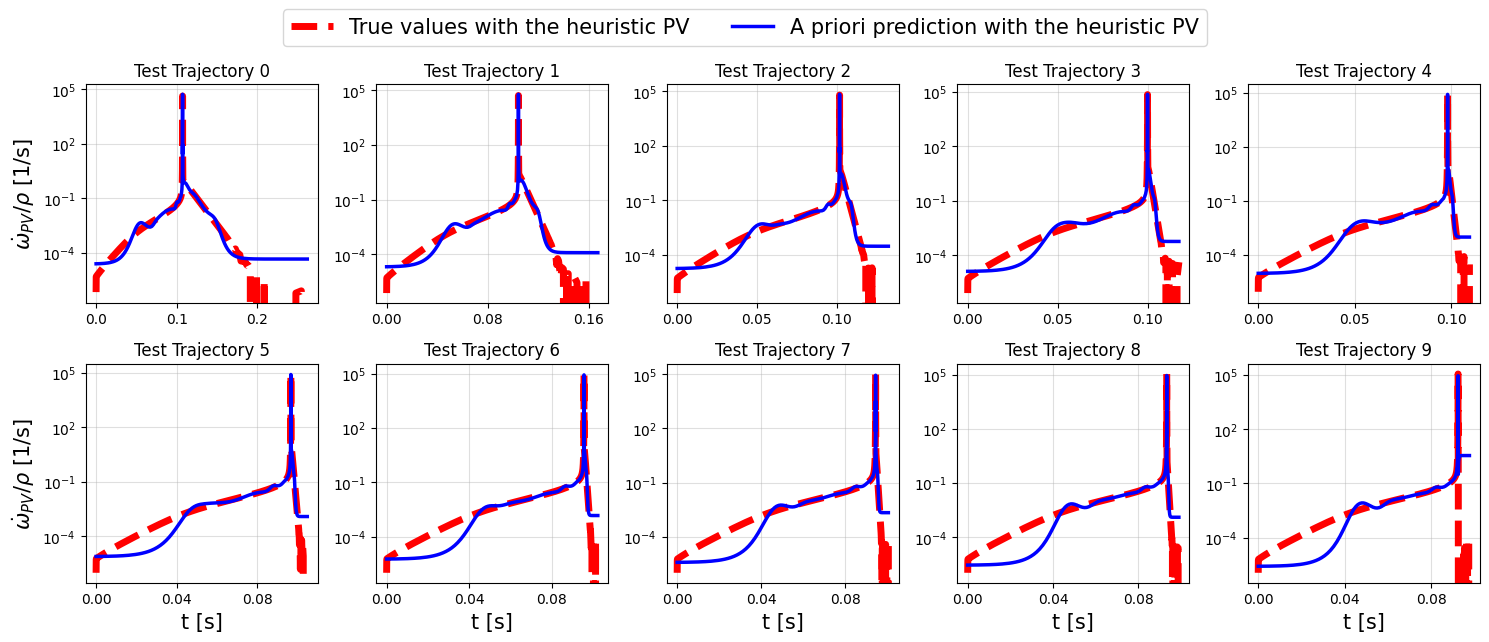

In [ ]:
save = True
pathSave = "C:/Users/admin/Documents/Parente/Figures/2024-PV-optimization/Paper/Results/Autoignition/A posteriori simulations/3.2 - ANN/A priori/"
name = f"Apriori_ANN_{regression_modelname}.png"
namePdf = f"Apriori_ANN_{regression_modelname}.pdf"

num_test_trajectories = 10
rows, cols = 2, 5  # Arrange in a 2x5 grid

fig, axes = plt.subplots(rows, cols, figsize=(15, 6))  # Define the grid
axes = axes.flatten()  # Flatten to 1D array for easy indexing

for i in range(num_test_trajectories):  
    #test source terms
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-sources-test-trajectories.h5", 'r') as hf:
        test_trajectory_source = pd.DataFrame(hf[f'test_trajectory_{i}'][:], columns = state_space_names)
        PV_Xu_source_test = test_trajectory_source["H2O"] - test_trajectory_source["H2"] - test_trajectory_source["O2"]
        PV_Xu_source_test = PV_Xu_source_test.to_numpy()
    
    #test time trajectories
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}time-test-trajectories.h5", 'r') as hf:
        test_trajectory_time = pd.DataFrame(hf[f'test_trajectory_{i}'][:])

    #print(PV_Xu_source_test)
    #print(prediction_test_trajectories[i])
    ax = axes[i]
    ax.plot(test_trajectory_time, PV_Xu_source_test, label="True values with the heuristic PV", color = "red", linestyle = "--", linewidth = 5)
    ax.plot(test_trajectory_time, prediction_test_trajectories[i], label="A priori prediction with the heuristic PV", color = "blue", linewidth = 2.5)
    ax.set_title(f"Test Trajectory {i}")
    ax.set_yscale("log")
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=2))
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=3))
    ax.yaxis.set_major_locator(LogLocator(base=10.0, numticks=6))
    ax.grid(True, linestyle='-', alpha=0.4)
    
    if(i>=num_test_trajectories-cols):
            ax.set_xlabel(f"t [s]", fontsize = 15)
    
    if(i%cols == 0):
            ax.set_ylabel(r'$\dot{\omega}_{PV} / \rho$ [1/s]', fontsize = 15)

#hide empty figures
for j in range(num_test_trajectories, len(axes)):
    axes[j].axis("off")

handles, labels = axes[0].get_legend_handles_labels()
custom_handles = [
    Line2D([0], [0], color=handle.get_color(),
           linestyle=handle.get_linestyle(),
           linewidth=handle.get_linewidth() * 1,  # Increase legend linewidth
           label=label)
    for handle, label in zip(handles, labels)
]
fig.legend(custom_handles, labels, loc='upper center', ncol=2, fontsize=15, frameon=True, bbox_to_anchor=(0.5, 1.08))

# Adjust layout
plt.tight_layout()
if(save):
    plt.savefig(pathSave + name, dpi=300, bbox_inches = "tight")
    plt.savefig(pathSave + namePdf, bbox_inches = "tight")
plt.show()

---
<h3> Heuristic PV (PV of Xu): Evolve the PV over time

In [7]:
class ODEXu(torch.nn.Module):

    def __init__(self, min_max_PV):
        super().__init__()
        self.outputs = [] #list to store the predicted source terms
        self.min_PV = min_max_PV[0]
        self.max_PV = min_max_PV[1]

    def forward(self, t, y):
        
        y_scaled = y.clone() #avoid in place changes
        if scaledManifold_Xu:
            y_scaled[0, 1] = (y_scaled[0, 1] - self.min_PV)/(self.max_PV - self.min_PV)

        f_PV = (y_scaled-mins_input_Xu) / (maxs_input_Xu - mins_input_Xu) - 0.5
        PV_source_predicted = model_regression_Xu(f_PV)
        PV_source_predicted = (PV_source_predicted+1) /2 * (maxs_output_Xu - mins_output_Xu) + mins_output_Xu

        if(log_transform == "continuous-symlog"):
            PV_source_predicted = inverse_symlog(PV_source_predicted, epsilon)
        elif(log_transform == "log"):
            PV_source_predicted = 10**PV_source_predicted

        
        self.outputs.append(PV_source_predicted.detach().numpy())

        zero = torch.tensor([[0.0]], dtype=PV_source_predicted.dtype, device=PV_source_predicted.device)
        f_PV_source_predicted = torch.cat((zero, PV_source_predicted), dim=1) #add a zero for the mixture fraction

        return f_PV_source_predicted

In [8]:
idx_start_simulation = 0
list_simulations_Xu = []
list_predicted_PV_source = []

#Get current date and time
now = datetime.now()
date_str = now.strftime("%Y-%m-%d")
time_str = now.strftime("%Hh%M")

print("Date:", date_str)
print("Hour:", time_str)

for i in range(10):

    with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
        test_trajectory = pd.DataFrame(hf[f'test_trajectory_{i}'][:], columns = state_space_names)
        if(Xu_H2O == "H2O"):
            PV_Xu_test = test_trajectory["H2O"]
        elif(Xu_H2O == "Xu"):
            PV_Xu_test = test_trajectory["H2O"] - test_trajectory["H2"] - test_trajectory["O2"]
        
        PV_Xu_test = PV_Xu_test.to_numpy().reshape(-1,1)
        f_PV_Xu_test = np.hstack((np.full(PV_Xu_test.shape[0], mixture_fractions_test[i]).reshape(-1,1), PV_Xu_test))
    
    #test time trajectories
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}time-test-trajectories.h5", 'r') as hf:
        test_trajectory_time = pd.DataFrame(hf[f'test_trajectory_{i}'][:])

    initial_condition = f_PV_Xu_test[idx_start_simulation,:]
    initial_condition = torch.tensor(initial_condition).unsqueeze(0)

    t_coordinates = test_trajectory_time[idx_start_simulation:].to_numpy().ravel()
    t_coordinates = torch.tensor(t_coordinates)
    
    ODEXu_instance = ODEXu([PV_Xu_test.min(), PV_Xu_test.max()])
    numerical_solution_Xu = odeint(ODEXu_instance, initial_condition, t_coordinates) #, method="rk4")
    numerical_solution_Xu = numerical_solution_Xu.squeeze(1)
    list_simulations_Xu.append(numerical_solution_Xu)
    list_predicted_PV_source.append(ODEXu_instance.outputs)

    MSE_Xu_test_simulation = mean_squared_error(PV_Xu_test[idx_start_simulation:], numerical_solution_Xu[:,1].detach().numpy())

    print(f"MSE for test trajectory {i}: {MSE_Xu_test_simulation}")

Date: 2025-09-04
Hour: 20h46
MSE for test trajectory 0: 0.04357131747631748
MSE for test trajectory 1: 0.0553584638005354
MSE for test trajectory 2: 0.06459191675244773
MSE for test trajectory 3: 0.07364854250939629
MSE for test trajectory 4: 0.08232135718142412
MSE for test trajectory 5: 0.09026172791473441
MSE for test trajectory 6: 0.0972928495153431
MSE for test trajectory 7: 0.10331096507491215
MSE for test trajectory 8: 0.10840319155417233
MSE for test trajectory 9: 0.11279468720518145


Use the MSE to quantitatively assess the quality of the simulationsn take the average MSE?

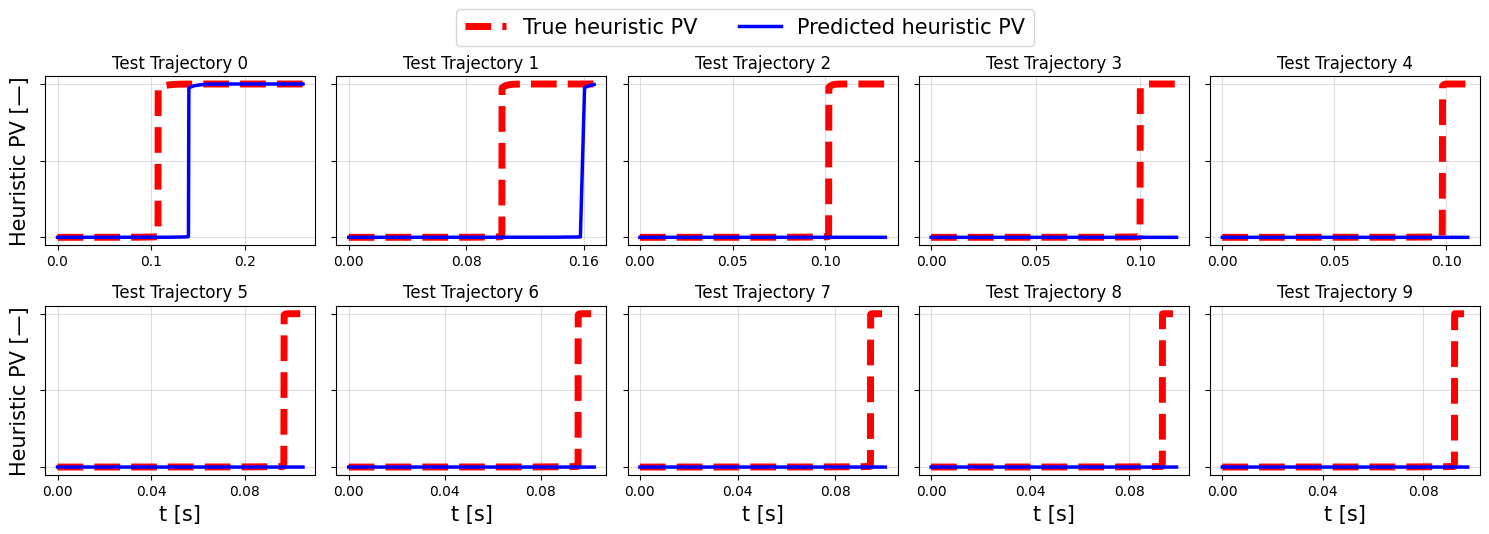

In [10]:
save = True
zoom = False
pathSave = "C:/Users/admin/Documents/Parente/Figures/2024-PV-optimization/Paper/Results/Autoignition/A posteriori simulations/3.2 - ANN/A posteriori/"

idx_start_simulation = 0

num_test_trajectories = 10
rows, cols = 2, 5 # Arrange in a 2x5 grid

fig, axes = plt.subplots(rows, cols, figsize=(15, 5))  # Define the grid
axes = axes.flatten()  # Flatten to 1D array for easy indexing

for i in range(num_test_trajectories):
    #test state space
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
        test_trajectory = pd.DataFrame(hf[f'test_trajectory_{i}'][:], columns = state_space_names)
        PV_Xu_test = test_trajectory["H2O"] - test_trajectory["H2"] - test_trajectory["O2"]
        PV_Xu_test = PV_Xu_test.to_numpy().reshape(-1,1)
        #PV_Xu_test = (PV_Xu_test - PV_Xu_test.min())/(PV_Xu_test.max() - PV_Xu_test.min())
        f_PV_Xu_test = np.hstack((np.full(PV_Xu_test.shape[0], mixture_fractions_test[i]).reshape(-1,1), PV_Xu_test))
    
    #test time trajectories
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}time-test-trajectories.h5", 'r') as hf:
        test_trajectory_time = pd.DataFrame(hf[f'test_trajectory_{i}'][:])
        
    ax = axes[i]

    PV_Xu_test_min = PV_Xu_test.min()
    PV_Xu_test_max = PV_Xu_test.max()

    if(zoom):
        ##############################################
        # Get the first and last index of the ignition
        ##############################################

        H2O_array = test_trajectory["H2O"].to_numpy()

        min_perc = 0.003
        max_perc = 0.995
        
        max_val = H2O_array.max()
        lower_threshold = min_perc * max_val
        upper_threshold = max_perc * max_val

        idx_1 = np.searchsorted(H2O_array, lower_threshold, side='left')
        idx_99 = np.searchsorted(H2O_array, upper_threshold, side='left')

        ax.plot(test_trajectory_time[idx_1:idx_99], (PV_Xu_test[idx_1:idx_99] - PV_Xu_test_min)/(PV_Xu_test_max - PV_Xu_test_min), label="True heuristic PV", color = "red", linestyle = "--", linewidth = 5)
        ax.plot(test_trajectory_time[idx_1:idx_99], (list_simulations_Xu[i][idx_1:idx_99,1] - PV_Xu_test_min)/(PV_Xu_test_max - PV_Xu_test_min), label="Predicted heuristic PV", color = "blue", linewidth = 2.5)

    else:
        ax.plot(test_trajectory_time[idx_start_simulation:], (PV_Xu_test[idx_start_simulation:] - PV_Xu_test_min)/(PV_Xu_test_max - PV_Xu_test_min), label="True heuristic PV", color = "red", linestyle = "--", linewidth = 5)
        ax.plot(test_trajectory_time[idx_start_simulation:], (list_simulations_Xu[i][:,1].detach().numpy() - PV_Xu_test_min)/(PV_Xu_test_max - PV_Xu_test_min), label="Predicted heuristic PV", color = "blue", linewidth = 2.5)
    
    ax.set_title(f"Test Trajectory {i}")
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=3))
    #ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=4))
    ax.set_yticks([0, 0.5, 1])
    ax.set_yticklabels([])
    ax.grid(True, linestyle='-', alpha=0.4)
    
    if(i>=num_test_trajectories-cols):
            ax.set_xlabel(f"t [s]", fontsize = 15)
    
    if(i%cols == 0):
            ax.set_ylabel('Heuristic PV [\u2014]', fontsize = 15)

#hide empty figures
for j in range(num_test_trajectories, len(axes)):
    axes[j].axis("off")

handles, labels = axes[0].get_legend_handles_labels()
custom_handles = [
    Line2D([0], [0], color=handle.get_color(),
           linestyle=handle.get_linestyle(),
           linewidth=handle.get_linewidth() * 1,  # Increase legend linewidth
           label=label)
    for handle, label in zip(handles, labels)
]
fig.legend(custom_handles, labels, loc='upper center', ncol=2, fontsize=15, frameon=True, bbox_to_anchor=(0.5, 1.08))

name = f"Heuristic vs optimized - A posteriori - Heuristic PV - ANN {regression_modelname}{f' - zoom {min_perc}-{max_perc}' if zoom else ''}.png"
namePdf = f"Heuristic vs optimized - A posteriori - Heuristic PV - ANN {regression_modelname}{f' - zoom {min_perc}-{max_perc}' if zoom else ''}.pdf"

# Adjust layout
plt.tight_layout()
if(save):
    plt.savefig(pathSave + name, dpi=300, bbox_inches = "tight")
    plt.savefig(pathSave + namePdf, bbox_inches = "tight")
plt.show()

<h3> Run the a posteriori simulation longer

In [ ]:
list_simulations_Xu_ext = []
list_predicted_PV_source_ext = []

#Get current date and time
now = datetime.now()
date_str = now.strftime("%Y-%m-%d")
time_str = now.strftime("%Hh%M")

print("Date:", date_str)
print("Hour:", time_str)

for i in range(10):

    with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
        test_trajectory = pd.DataFrame(hf[f'test_trajectory_{i}'][:], columns = state_space_names)
        if(Xu_H2O == "H2O"):
            PV_Xu_test = test_trajectory["H2O"]
        elif(Xu_H2O == "Xu"):
            PV_Xu_test = test_trajectory["H2O"] - test_trajectory["H2"] - test_trajectory["O2"]
        
        PV_Xu_test = PV_Xu_test.to_numpy().reshape(-1,1)
        f_PV_Xu_test = np.hstack((np.full(PV_Xu_test.shape[0], mixture_fractions_test[i]).reshape(-1,1), PV_Xu_test))
    
    #test time trajectories
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}time-test-trajectories.h5", 'r') as hf:
        test_trajectory_time = pd.DataFrame(hf[f'test_trajectory_{i}'][:])

    initial_condition = f_PV_Xu_test[0,:]
    initial_condition = torch.tensor(initial_condition).unsqueeze(0)

    t_coordinates = test_trajectory_time[0:].to_numpy().ravel()
    t_coordinates = torch.tensor(t_coordinates)
    deltaTime = t_coordinates[-1] - t_coordinates[-2]

    last_value = t_coordinates[-1]
    new_times = []

    next_time = last_value + deltaTime
    while next_time <= 2:
        new_times.append(next_time.item())
        next_time += deltaTime

    #Add extension to the current tensor
    if new_times:
        extension = torch.tensor(new_times, dtype=torch.float32)
        t_coordinates = torch.cat((t_coordinates, extension))
    
    ODEXu_instance = ODEXu([PV_Xu_test.min(), PV_Xu_test.max()])
    numerical_solution_Xu = odeint(ODEXu_instance, initial_condition, t_coordinates) #, method="rk4")
    numerical_solution_Xu = numerical_solution_Xu.squeeze(1)
    list_simulations_Xu_ext.append(numerical_solution_Xu)
    list_predicted_PV_source_ext.append(ODEXu_instance.outputs)

    #MSE_Xu_test_simulation = mean_squared_error(PV_Xu_test[idx_start_simulation:], numerical_solution_Xu[:,1].detach().numpy())


Date: 2025-09-04
Hour: 20h46


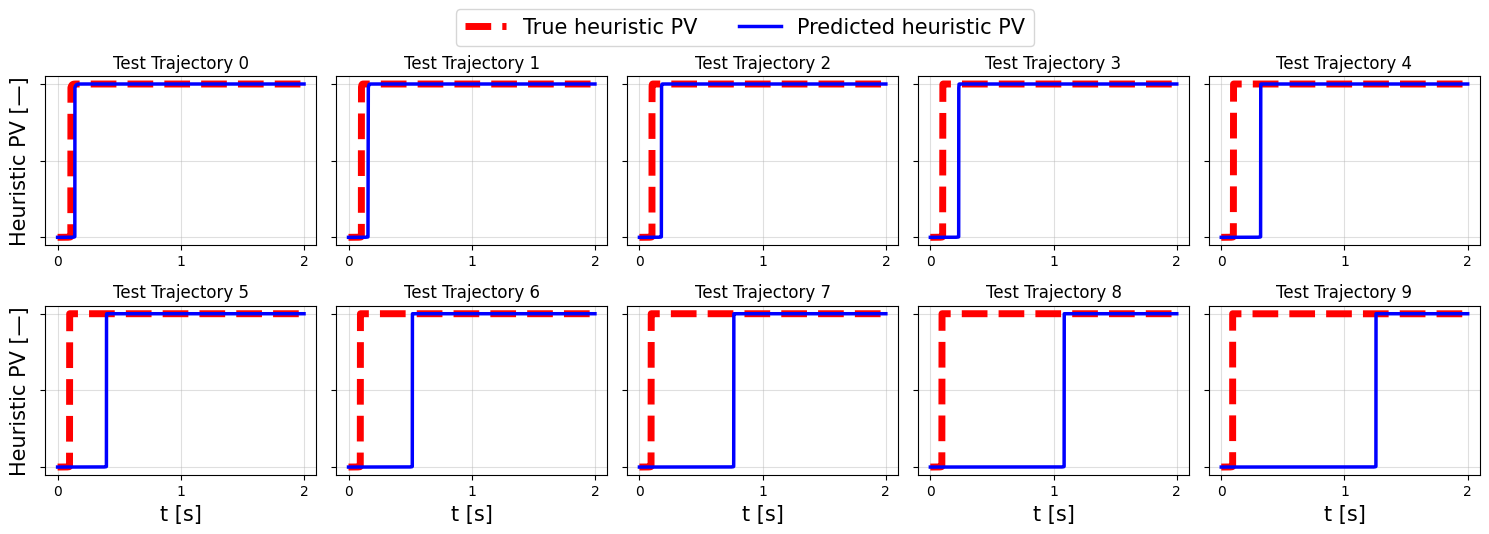

In [ ]:
save = True
zoom = False
pathSave = "C:/Users/admin/Documents/Parente/Figures/2024-PV-optimization/Paper/Results/Autoignition/A posteriori simulations/3.2 - ANN/A posteriori/"
name = f"Heuristic vs optimized - A posteriori - Heuristic PV - ANN {regression_modelname}{f' - zoom {min_perc}-{max_perc}' if zoom else ''}_timeExt.png"
namePdf = f"Heuristic vs optimized - A posteriori - Heuristic PV - ANN {regression_modelname}{f' - zoom {min_perc}-{max_perc}' if zoom else ''}_timeExt.pdf"

num_test_trajectories = 10
rows, cols = 2, 5  # Arrange in a 2x5 grid

fig, axes = plt.subplots(rows, cols, figsize=(15, 5))  # Define the grid
axes = axes.flatten()  # Flatten to 1D array for easy indexing

for i in range(10):
    #test state space
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
        test_trajectory = pd.DataFrame(hf[f'test_trajectory_{i}'][:], columns = state_space_names)
        if(Xu_H2O == "H2O"):
            PV_Xu_test = test_trajectory["H2O"]
        elif(Xu_H2O == "Xu"):
            PV_Xu_test = test_trajectory["H2O"] - test_trajectory["H2"] - test_trajectory["O2"]
        PV_Xu_test = PV_Xu_test.to_numpy().reshape(-1,1)
        #PV_Xu_test = (PV_Xu_test - PV_Xu_min_train)/(PV_Xu_max_train - PV_Xu_min_train)
        f_PV_Xu_test = np.hstack((np.full(PV_Xu_test.shape[0], mixture_fractions_test[i]).reshape(-1,1), PV_Xu_test))
    
    #test time trajectories
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}time-test-trajectories.h5", 'r') as hf:
        test_trajectory_time = pd.DataFrame(hf[f'test_trajectory_{i}'][:])
    
    test_trajectory_time = test_trajectory_time.to_numpy().ravel()
    test_trajectory_time = torch.tensor(test_trajectory_time)
    deltaTime = test_trajectory_time[-1] - test_trajectory_time[-2]

    last_value = test_trajectory_time[-1]
    new_times = []

    next_time = last_value + deltaTime
    while next_time <= 2:
        new_times.append(next_time.item())
        next_time += deltaTime

    #Add extension to the current tensor
    if new_times:
        extension = torch.tensor(new_times, dtype=torch.float32)
        test_trajectory_time_ext = torch.cat((test_trajectory_time, extension))

        last_value = PV_Xu_test[-1]
        extension = np.tile(last_value, (len(new_times), 1))  #extension with last value of PV_Xu_test
        PV_Xu_test_ext = np.vstack((PV_Xu_test, extension)) #concatenate the extension with the original value

    min_PV = PV_Xu_test_ext.min()
    max_PV = PV_Xu_test_ext.max()

    ax = axes[i]
    ax.plot(test_trajectory_time_ext, (PV_Xu_test_ext-min_PV)/(max_PV - min_PV), label="True heuristic PV", color = "red", linestyle = "--", linewidth = 5)
    ax.plot(test_trajectory_time_ext, (list_simulations_Xu_ext[i][:,1].detach().numpy()-min_PV)/(max_PV - min_PV), label="Predicted heuristic PV", color = "blue", linewidth = 2.5)
    ax.set_title(f"Test Trajectory {i}")
    ax.set_xticks([0, 1, 2])
    ax.set_yticks([0, 0.5, 1])
    ax.set_yticklabels([])
    ax.grid(True, linestyle='-', alpha=0.4)
    
    if(i>=num_test_trajectories-cols):
            ax.set_xlabel(f"t [s]", fontsize = 15)
    
    if(i%cols == 0):
            ax.set_ylabel('Heuristic PV [\u2014]', fontsize = 15)

#hide empty figures
for j in range(num_test_trajectories, len(axes)):
    axes[j].axis("off")

handles, labels = axes[0].get_legend_handles_labels()
custom_handles = [
    Line2D([0], [0], color=handle.get_color(),
           linestyle=handle.get_linestyle(),
           linewidth=handle.get_linewidth() * 1,  # Increase legend linewidth
           label=label)
    for handle, label in zip(handles, labels)
]
fig.legend(custom_handles, labels, loc='upper center', ncol=2, fontsize=15, frameon=True, bbox_to_anchor=(0.5, 1.08))

# Adjust layout
plt.tight_layout()
if(save):
    plt.savefig(pathSave + name, dpi=300, bbox_inches = "tight")
    plt.savefig(pathSave + namePdf, bbox_inches = "tight")
plt.show()

In [10]:
def ignition_time_difference(time_array, pv_true, pv_pred, threshold=0.99):
    """
    Compute the time difference between true and predicted PV ignition times.
    
    Parameters
    ----------
    time_array : np.ndarray
        1D array of time values.
    pv_true : np.ndarray
        1D array of true PV values (same length as time_array).
    pv_pred : np.ndarray
        1D array of predicted PV values (same length as time_array).
    threshold : float, optional
        The PV threshold for ignition (default: 0.99).
    
    Returns
    -------
    float or None
        The time difference (predicted - true) when both trajectories reach
        the threshold. Returns None if either trajectory never reaches it.
    """
    # Find first index where true PV >= threshold
    true_idx = np.argmax(pv_true >= threshold) if np.any(pv_true >= threshold) else None
    # Find first index where predicted PV >= threshold
    pred_idx = np.argmax(pv_pred >= threshold) if np.any(pv_pred >= threshold) else None

    if true_idx is None or pred_idx is None:
        return None  # one of them never reaches threshold

    true_time = time_array[true_idx]
    pred_time = time_array[pred_idx]

    return np.round(pred_time - true_time, 2)


for i in range(10):
    #test state space
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
        test_trajectory = pd.DataFrame(hf[f'test_trajectory_{i}'][:], columns = state_space_names)
        if(Xu_H2O == "H2O"):
            PV_Xu_test = test_trajectory["H2O"]
        elif(Xu_H2O == "Xu"):
            PV_Xu_test = test_trajectory["H2O"] - test_trajectory["H2"] - test_trajectory["O2"]
        PV_Xu_test = PV_Xu_test.to_numpy().reshape(-1,1)
        #PV_Xu_test = (PV_Xu_test - PV_Xu_min_train)/(PV_Xu_max_train - PV_Xu_min_train)
        f_PV_Xu_test = np.hstack((np.full(PV_Xu_test.shape[0], mixture_fractions_test[i]).reshape(-1,1), PV_Xu_test))
    
    #test time trajectories
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}time-test-trajectories.h5", 'r') as hf:
        test_trajectory_time = pd.DataFrame(hf[f'test_trajectory_{i}'][:])
    
    test_trajectory_time = test_trajectory_time.to_numpy().ravel()
    test_trajectory_time = torch.tensor(test_trajectory_time)
    deltaTime = test_trajectory_time[-1] - test_trajectory_time[-2]

    last_value = test_trajectory_time[-1]
    new_times = []

    next_time = last_value + deltaTime
    while next_time <= 2:
        new_times.append(next_time.item())
        next_time += deltaTime

    #Add extension to the current tensor
    if new_times:
        extension = torch.tensor(new_times, dtype=torch.float32)
        test_trajectory_time_ext = torch.cat((test_trajectory_time, extension))

        last_value = PV_Xu_test[-1]
        extension = np.tile(last_value, (len(new_times), 1))  #extension with last value of PV_Xu_test
        PV_Xu_test_ext = np.vstack((PV_Xu_test, extension)) #concatenate the extension with the original value

    min_PV = PV_Xu_test_ext.min()
    max_PV = PV_Xu_test_ext.max()

    true_PV_norm = (PV_Xu_test_ext - min_PV) / (max_PV - min_PV)
    pred_PV_norm = (list_simulations_Xu_ext[i][:,1] - min_PV) / (max_PV - min_PV)

    # Compute ignition time difference
    dt = ignition_time_difference(np.array(test_trajectory_time_ext), true_PV_norm, pred_PV_norm.detach().numpy())
    print(f"Ignition time difference of traj {i}:", dt, "s")

Ignition time difference of traj 0: 0.03 s
Ignition time difference of traj 1: 0.06 s
Ignition time difference of traj 2: 0.08 s
Ignition time difference of traj 3: 0.13 s
Ignition time difference of traj 4: 0.22 s
Ignition time difference of traj 5: 0.3 s
Ignition time difference of traj 6: 0.42 s
Ignition time difference of traj 7: 0.67 s
Ignition time difference of traj 8: 0.99 s
Ignition time difference of traj 9: 1.16 s


<h3> Reconstruction to the full state space

In [13]:
#Load the model

with open(f'{path_regression_model}{regression_full_modelname}_metadata.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)
model_params = loaded_dict["model_params"]

mins_input_full_Xu = loaded_dict["mins_input"]
maxs_input_full_Xu = loaded_dict["maxs_input"]
mins_output_full_Xu = loaded_dict["mins_output"]
maxs_output_full_Xu = loaded_dict["maxs_output"]

print(f'epochs {loaded_dict["max_epo"]}: layers {loaded_dict["neuron_layers"]}; batch size {loaded_dict["batch_size"]}; final MSE {loaded_dict["final validation error"]}')

model_regression_full_Xu = ANN_regression(**model_params)
model_regression_full_Xu.load_state_dict(torch.load(f"{path_regression_model}{regression_full_modelname}_model.pth", weights_only=False))

Output_species = loaded_dict["Output_species"]

for i in range(10):
    f_PV_Xu = list_simulations_Xu[i][:]
    f_PV_Xu_scaled = (f_PV_Xu - mins_input_full_Xu)/(maxs_input_full_Xu - mins_input_full_Xu) - 0.5
    prediction = model_regression_full_Xu(f_PV_Xu_scaled)

epochs 500: layers [5, 10, 10]; batch size 1000; final MSE 0.00042600818564002827


<hr style="border:2px solid gray">
<h3> Optimized PV: Closure model - f-PV to PV source

In [14]:
#Load the ANN closure model

with open(f'{path_regression_model}{regression_modelname_optimized}_metadata.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)
model_params = loaded_dict["model_params"]

mins_input_optimized = loaded_dict["mins_input"]
maxs_input_optimized = loaded_dict["maxs_input"]
mins_output_optimized = loaded_dict["mins_output"]
maxs_output_optimized = loaded_dict["maxs_output"]

log_PVsource_optimized = loaded_dict["log_PVsource"]

epsilon = loaded_dict["epsilon"]
log_transform_opt = loaded_dict["log transformation"]
scaledManifold_opt = loaded_dict["scaled manifold"]

#signPV_inverted = loaded_dict["signPV_inverted"]
PV_optimized_source_train_min = loaded_dict["PV_optimized_source_train_min"]
PV_optimized_source_train_max = loaded_dict["PV_optimized_source_train_max"]

model_regression_optimized = ANN_regression(**model_params)
model_regression_optimized.load_state_dict(torch.load(f"{path_regression_model}{regression_modelname_optimized}_model.pth", weights_only=False))

filename_PV_model = loaded_dict["filename_PV_model"]

filename_metadata = filename_PV_model + "_metadata.pkl"
path_metadata = "metadata/"
filename_species_names = "Xu-state-space-names.csv"
path_data = "data-files/"

loader = loadData(filename_species_names, path_metadata, filename_metadata)
idx_species_removed = loader.metadata["list idx species removed source"] if loader.metadata["dataset_type"]=="autoignition_augm" else loader.metadata["idx species removed"]
id_model = loader.metadata["Training_id"]
PV_model = loader.loadModel()

weight_inversion = loaded_dict["weight_inversion"]
if(weight_inversion):
    with torch.no_grad():  # Ensures we do not track gradients for this operation
        PV_model.encoder_species.weight.mul_(-1)

state_space_names_DNS = np.genfromtxt(f"{path_data}Xu-state-space-names.csv", delimiter=",", dtype=str)

In [ ]:
prediction_test_trajectories_optimized = []

for i in range(10):
    #test state space
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
        test_trajectory = pd.DataFrame(hf[f'test_trajectory_{i}'][:], columns = state_space_names)
        state_space_test_DNS = test_trajectory[state_space_names_DNS].to_numpy()
        
        PV_optimized_test = PV_model.get_PV(torch.from_numpy(np.delete(state_space_test_DNS, idx_species_removed, axis=1))).detach().numpy()

        if(scaledManifold_opt):
            PV_optimized_test = (PV_optimized_test - PV_optimized_test.min())/(PV_optimized_test.max() - PV_optimized_test.min())

        f_PV_optimized_test = np.hstack((np.full(PV_optimized_test.shape[0], mixture_fractions_test[i]).reshape(-1,1), PV_optimized_test.reshape(-1,1)))
        f_PV_optimized_test = torch.tensor(f_PV_optimized_test)
        f_PV_optimized_test_scaled =  (f_PV_optimized_test - mins_input_optimized) / (maxs_input_optimized - mins_input_optimized) - 0.5
         
    #test source terms
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-sources-test-trajectories.h5", 'r') as hf:
        test_trajectory_source = pd.DataFrame(hf[f'test_trajectory_{i}'][:], columns = state_space_names)
        state_space_source_test_DNS = test_trajectory_source[state_space_names_DNS].to_numpy()
        PV_optimized_source_test = PV_model.get_PV(torch.from_numpy(np.delete(state_space_source_test_DNS, idx_species_removed, axis=1))).detach().numpy()
    
    PV_optimized_source_test_predicted = model_regression_optimized(f_PV_optimized_test_scaled)
    PV_optimized_source_test_predicted =  (PV_optimized_source_test_predicted+1) /2 * (maxs_output_optimized - mins_output_optimized) + mins_output_optimized
    PV_optimized_source_test_predicted = PV_optimized_source_test_predicted.detach().numpy()
    if(log_PVsource_optimized):
        if(log_transform_opt == "continuous-symlog"):
            PV_optimized_source_test_predicted = inverse_symlog(PV_optimized_source_test_predicted, epsilon)
        elif(log_transform_opt == "log"):
            PV_optimized_source_test_predicted = 10**PV_optimized_source_test_predicted
    prediction_test_trajectories_optimized.append(PV_optimized_source_test_predicted)
    MSE_optimized_test = mean_squared_error(PV_optimized_source_test, PV_optimized_source_test_predicted)

    print(f"MSE of optimized PV for test trajectory {i}: {MSE_optimized_test}")

MSE of optimized PV for test trajectory 0: 597516.0709230277
MSE of optimized PV for test trajectory 1: 270536.8781776052
MSE of optimized PV for test trajectory 2: 1731125.2667566978
MSE of optimized PV for test trajectory 3: 749228.451607459
MSE of optimized PV for test trajectory 4: 1133393.9158286462
MSE of optimized PV for test trajectory 5: 1827222.3824165438
MSE of optimized PV for test trajectory 6: 703390.4756399866
MSE of optimized PV for test trajectory 7: 1691244.6253564458
MSE of optimized PV for test trajectory 8: 6750378.755870104
MSE of optimized PV for test trajectory 9: 15783710.499540951


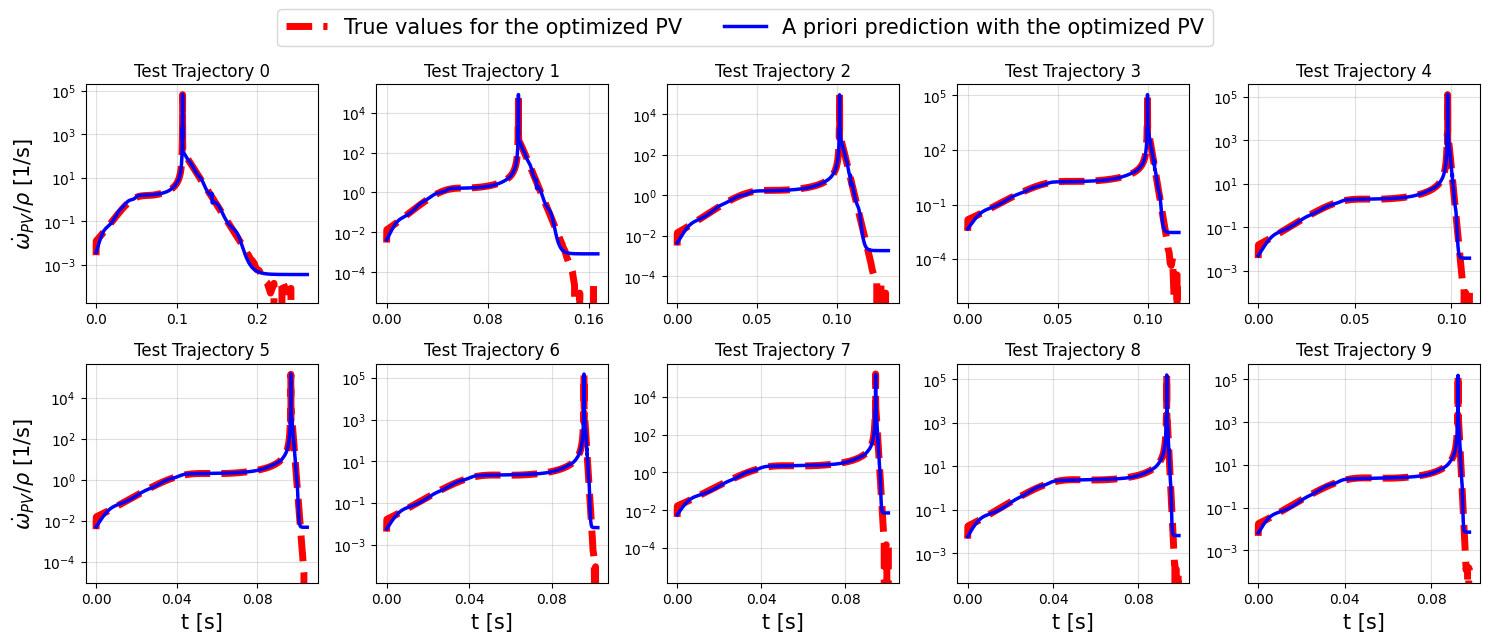

In [ ]:
save = True
pathSave = "C:/Users/admin/Documents/Parente/Figures/2024-PV-optimization/Paper/Results/Autoignition/A posteriori simulations/3.2 - ANN/A priori/"
name = f"Apriori_ANN_{regression_modelname_optimized}.png"
namePdf = f"Apriori_ANN_{regression_modelname_optimized}.pdf"

num_test_trajectories = 10
rows, cols = 2, 5  # Arrange in a 2x5 grid

fig, axes = plt.subplots(rows, cols, figsize=(15, 6))  # Define the grid
axes = axes.flatten()  # Flatten to 1D array for easy indexing

for i in range(num_test_trajectories):
    #test source terms
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-sources-test-trajectories.h5", 'r') as hf:
        test_trajectory_source = pd.DataFrame(hf[f'test_trajectory_{i}'][:], columns = state_space_names)
        state_space_source_test_DNS = test_trajectory_source[state_space_names_DNS].to_numpy()
        PV_optimized_source_test = PV_model.get_PV(torch.from_numpy(np.delete(state_space_source_test_DNS, idx_species_removed, axis=1))).detach().numpy()

    #test time trajectories
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}time-test-trajectories.h5", 'r') as hf:
        test_trajectory_time = pd.DataFrame(hf[f'test_trajectory_{i}'][:])
        
    ax = axes[i]
    ax.plot(test_trajectory_time, PV_optimized_source_test, label="True values for the optimized PV", color = "red", linestyle = "--", linewidth = 5)
    ax.plot(test_trajectory_time, prediction_test_trajectories_optimized[i], label="A priori prediction with the optimized PV", color = "blue", linewidth = 2.5)
    ax.set_title(f"Test Trajectory {i}")
    ax.set_yscale("log")
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=3))
    ax.yaxis.set_major_locator(LogLocator(base=10.0, numticks=6))
    ax.grid(True, linestyle='-', alpha=0.4)
    
    if(i>=num_test_trajectories-cols):
            ax.set_xlabel(f"t [s]", fontsize = 15)
    
    if(i%cols == 0):
            ax.set_ylabel(r'$\dot{\omega}_{PV} / \rho$ [1/s]', fontsize = 15)

#hide empty figures
for j in range(num_test_trajectories, len(axes)):
    axes[j].axis("off")

handles, labels = axes[0].get_legend_handles_labels()
custom_handles = [
    Line2D([0], [0], color=handle.get_color(),
           linestyle=handle.get_linestyle(),
           linewidth=handle.get_linewidth() * 1,  # Increase legend linewidth
           label=label)
    for handle, label in zip(handles, labels)
]
fig.legend(custom_handles, labels, loc='upper center', ncol=2, fontsize=15, frameon=True, bbox_to_anchor=(0.5, 1.08))

# Adjust layout
plt.tight_layout()
if(save):
    plt.savefig(pathSave + name, dpi=300, bbox_inches = "tight")
    plt.savefig(pathSave + namePdf, bbox_inches = "tight")
plt.show()

C:\Windows\Temp\ipykernel_23324\3007871070.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  greys = cm.get_cmap('Greys')


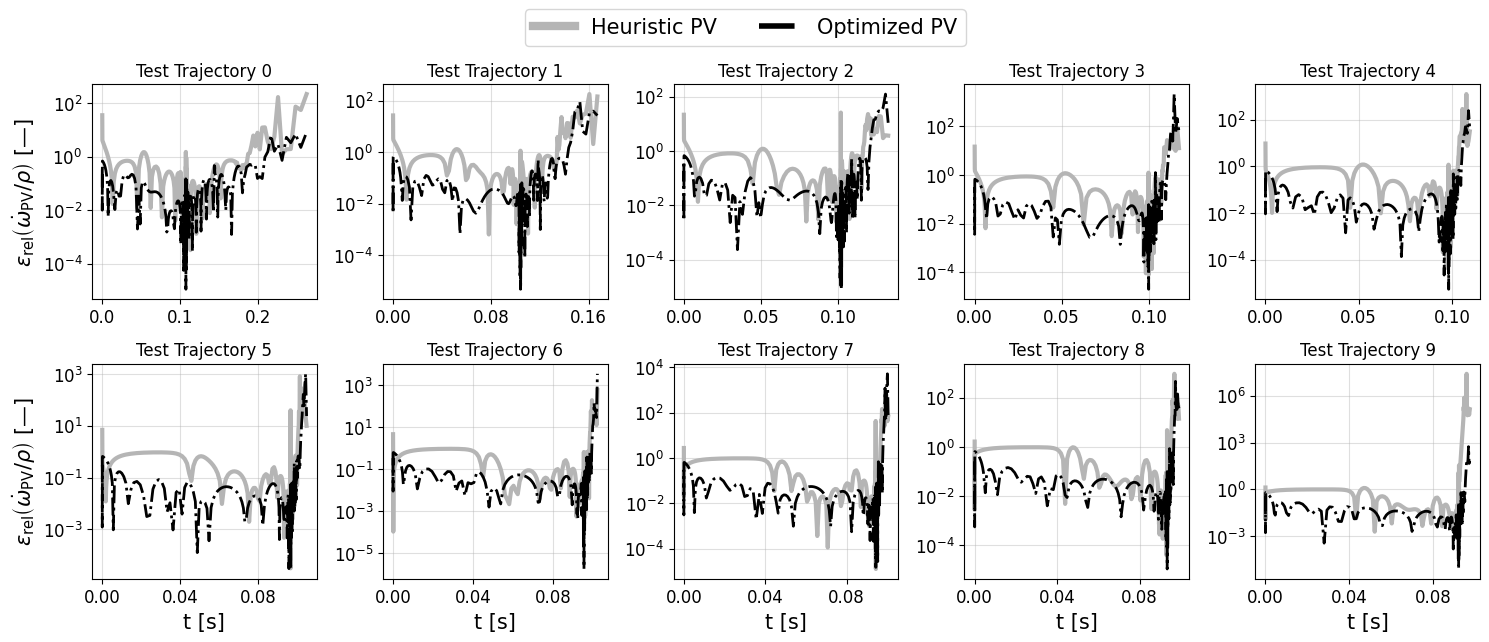

In [17]:
save = True
pathSave = "C:/Users/admin/Documents/Parente/Figures/2024-PV-optimization/Paper/Results/Autoignition/A posteriori simulations/3.2 - ANN/A priori/"
name = f"Heuristic vs optimized {id_model} - A priori - relative Error comparison - ANN"
namePdf = f"Heuristic vs optimized {id_model} - A priori - relative Error comparison - ANN.pdf"

num_test_trajectories = 10
rows, cols = 2, 5  # Arrange in a 2x5 grid

fig, axes = plt.subplots(rows, cols, figsize=(15, 6))  # Define the grid
axes = axes.flatten()  # Flatten to 1D array for easy indexing

greys = cm.get_cmap('Greys')

for i in range(num_test_trajectories):
    #test source terms
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-sources-test-trajectories.h5", 'r') as hf:
        test_trajectory_source = pd.DataFrame(hf[f'test_trajectory_{i}'][:], columns = state_space_names)
        state_space_source_test_DNS = test_trajectory_source[state_space_names_DNS].to_numpy()
        PV_optimized_source_test = PV_model.get_PV(torch.from_numpy(np.delete(state_space_source_test_DNS, idx_species_removed, axis=1))).detach().numpy()
        
        PV_Xu_source_test = test_trajectory_source["H2O"] - test_trajectory_source["H2"] - test_trajectory_source["O2"]
        PV_Xu_source_test = PV_Xu_source_test.to_numpy()

    #test time trajectories
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}time-test-trajectories.h5", 'r') as hf:
        test_trajectory_time = pd.DataFrame(hf[f'test_trajectory_{i}'][:])
        
    ax = axes[i]
    relativeErrorXu = np.abs(PV_Xu_source_test.flatten() - prediction_test_trajectories[i].flatten())/np.abs(PV_Xu_source_test.flatten())
    relErrorOptimized = np.abs(prediction_test_trajectories_optimized[i].flatten() - PV_optimized_source_test.flatten())/np.abs(PV_optimized_source_test.flatten())
    ax.plot(test_trajectory_time, relativeErrorXu, label = "Heuristic PV", color = greys(0.4), linewidth = 3, linestyle = "-")
    ax.plot(test_trajectory_time, relErrorOptimized, label = "Optimized PV", color = "k", linewidth = 2, linestyle = "-.")
    ax.set_title(f"Test Trajectory {i}")
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=3))
    ax.set_yscale("log")
    ax.tick_params(axis='both', labelsize=12)
    ax.yaxis.set_major_locator(LogLocator(base=10.0, numticks=6))
    ax.grid(True, linestyle='-', alpha=0.4)

    
    if(i>=num_test_trajectories-cols):
            ax.set_xlabel(f"t [s]", fontsize = 15)
    
    if(i%cols == 0):
            ax.set_ylabel(r"$\epsilon_{\mathrm{rel}}\left( \dot{\omega}_{\mathrm{PV}} / \rho \right)$" + " [\u2014]", fontsize=15)

handles, labels = axes[0].get_legend_handles_labels()
custom_handles = [
    Line2D([0], [0], color=handle.get_color(),
           linestyle=handle.get_linestyle(),
           linewidth=handle.get_linewidth() * 2,  # Increase legend linewidth
           label=label)
    for handle, label in zip(handles, labels)
]
fig.legend(custom_handles, labels, loc='upper center', ncol=2, fontsize=15, frameon=True, bbox_to_anchor=(0.5, 1.08))

#hide empty figures
for j in range(num_test_trajectories, len(axes)):
    axes[j].axis("off")

# Adjust layout
plt.tight_layout()
if(save):
    plt.savefig(pathSave + name, dpi=300, bbox_inches = "tight")
    plt.savefig(pathSave + namePdf, bbox_inches = "tight")
plt.show()

## Figures for paper: A priori

C:\Windows\Temp\ipykernel_39392\456745358.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  greys = cm.get_cmap('Greys')


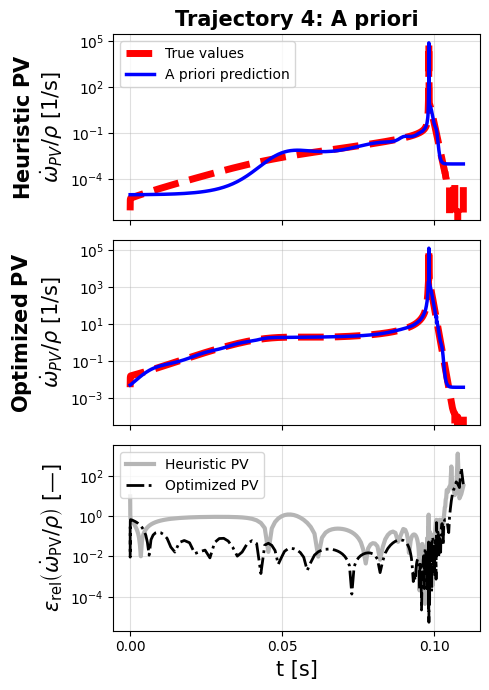

In [14]:
i = 4  # index of trajectory

save = True
pathSave = "C:/Users/admin/Documents/Parente/Figures/2024-PV-optimization/Paper/Results/Autoignition/A posteriori simulations/3.2 - ANN/A priori/"
name = f"Apriori_ANN_combination_prediction_and_relative_error_Heuristic_and_optimized.png"
namePDF = f"Apriori_ANN_combination_prediction_and_relative_error_Heuristic_and_optimized.pdf"

fig, axes = plt.subplots(3, 1, figsize=(5, 7))
greys = cm.get_cmap('Greys')

# -----------------------------
# Load data once for trajectory 4
# -----------------------------
with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-sources-test-trajectories.h5", 'r') as hf:
    test_trajectory_source = pd.DataFrame(hf[f'test_trajectory_{i}'][:], columns=state_space_names)
    state_space_source_test_DNS = test_trajectory_source[state_space_names_DNS].to_numpy()
    PV_optimized_source_test = PV_model.get_PV(
        torch.from_numpy(np.delete(state_space_source_test_DNS, idx_species_removed, axis=1))
    ).detach().numpy()

    PV_Xu_source_test = test_trajectory_source["H2O"] - test_trajectory_source["H2"] - test_trajectory_source["O2"]
    PV_Xu_source_test = PV_Xu_source_test.to_numpy()

with h5py.File(f"{path_data_autoignition}{filename_autoignition}time-test-trajectories.h5", 'r') as hf:
    test_trajectory_time = pd.DataFrame(hf[f'test_trajectory_{i}'][:])

# -----------------------------
# Plot 1: Heuristic PV
# -----------------------------
ax = axes[0]
ax.plot(test_trajectory_time, PV_Xu_source_test,
        label="True values", color="red",
        linestyle="--", linewidth=5)
ax.plot(test_trajectory_time, prediction_test_trajectories[i],
        label="A priori prediction", color="blue",
        linewidth=2.5)
ax.set_title(f"Trajectory {i}: A priori", fontsize = 15, fontweight="bold")
ax.set_yscale("log")
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=3))
ax.set_xticklabels([])
ax.yaxis.set_major_locator(LogLocator(base=10.0, numticks=6))
ax.grid(True, linestyle='-', alpha=0.4)
ax.set_ylabel(r'$\mathbf{Heuristic\ PV}$' + '\n' + r'$\dot{\omega}_{PV} / \rho$ [1/s]', fontsize=15)
ax.legend(fontsize = 10, ncols = 1, loc = "upper left")

# -----------------------------
# Plot 2: Optimized PV
# -----------------------------
ax = axes[1]
ax.plot(test_trajectory_time, PV_optimized_source_test,
        label="True values for the optimized PV", color="red",
        linestyle="--", linewidth=5)
ax.plot(test_trajectory_time, prediction_test_trajectories_optimized[i],
        label="A priori prediction with the optimized PV", color="blue",
        linewidth=2.5)
ax.set_yscale("log")
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=3))
ax.set_xticklabels([])
ax.yaxis.set_major_locator(LogLocator(base=10.0, numticks=6))
ax.grid(True, linestyle='-', alpha=0.4)
ax.set_ylabel(r'$\mathbf{Optimized\ PV}$' + '\n' + r'$\dot{\omega}_{PV} / \rho$ [1/s]', fontsize=15)

# -----------------------------
# Plot 3: Relative Error
# -----------------------------
relativeErrorXu = np.abs(PV_Xu_source_test.flatten() - prediction_test_trajectories[i].flatten()) / np.abs(PV_Xu_source_test.flatten())
relErrorOptimized = np.abs(prediction_test_trajectories_optimized[i].flatten() - PV_optimized_source_test.flatten()) / np.abs(PV_optimized_source_test.flatten())

ax = axes[2]
ax.plot(test_trajectory_time, relativeErrorXu,
        label="Heuristic PV", color=greys(0.4), linewidth=3, linestyle="-")
ax.plot(test_trajectory_time, relErrorOptimized,
        label="Optimized PV", color="k", linewidth=2, linestyle="-.")
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=3))
ax.set_yscale("log")
ax.yaxis.set_major_locator(LogLocator(base=10.0, numticks=6))
ax.grid(True, linestyle='-', alpha=0.4)
ax.set_xlabel("t [s]", fontsize=15)
ax.set_ylabel(r"$\epsilon_{\mathrm{rel}}\left( \dot{\omega}_{\mathrm{PV}} / \rho \right)$" + " [\u2014]", fontsize=15)
ax.legend(fontsize = 10, ncols = 1, loc = "upper left")

# -----------------------------
# Adjust and save
# -----------------------------
plt.tight_layout()
if save:
    plt.savefig(pathSave + name, dpi=1000, bbox_inches="tight")
    plt.savefig(pathSave + namePDF, bbox_inches="tight")
plt.show()


---
<h3> PV optimized: Evolve the PV over time

In [ ]:
class ODEOptimized(torch.nn.Module):

    def __init__(self, min_max_PV):
        super().__init__()
        self.min_PV = min_max_PV[0]
        self.max_PV = min_max_PV[1]

    def forward(self, t, y):
        y_scaled = y.clone() #avoid in place changes
        if scaledManifold_opt:
            y_scaled[1] = (y_scaled[1] - self.min_PV)/(self.max_PV - self.min_PV)
                

        
        f_PV = (y_scaled-mins_input_optimized) / (maxs_input_optimized - mins_input_optimized) - 0.5
        PV_source_predicted = model_regression_optimized(f_PV)
        PV_source_predicted = (PV_source_predicted+1) /2 * (maxs_output_optimized - mins_output_optimized) + mins_output_optimized
        
        if(log_transform_opt == "continuous-symlog"):
            PV_optimized_source_test_predicted = inverse_symlog(PV_source_predicted, epsilon)
        elif(log_transform_opt == "log"):
            PV_optimized_source_test_predicted = 10**PV_source_predicted

        zero = torch.tensor([[0.0]], dtype=PV_optimized_source_test_predicted.dtype, device=PV_optimized_source_test_predicted.device)
        f_PV_source_predicted = torch.cat((zero, PV_optimized_source_test_predicted), dim=1) #add a zero for the mixture fraction
        

        return f_PV_source_predicted.squeeze()

In [ ]:
idx_start_simulation = 0
list_simulations_optimized = []

#Get current date and time
now = datetime.now()
date_str = now.strftime("%Y-%m-%d")
time_str = now.strftime("%Hh%M")

print("Predicted")

for i in range(10):

    with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
        test_trajectory = pd.DataFrame(hf[f'test_trajectory_{i}'][:], columns = state_space_names)
        state_space_test_DNS = test_trajectory[state_space_names_DNS].to_numpy()
        
        PV_optimized_test = PV_model.get_PV(torch.from_numpy(np.delete(state_space_test_DNS, idx_species_removed, axis=1))).detach().numpy()

        f_PV_optimized_test = np.hstack((np.full(PV_optimized_test.shape[0], mixture_fractions_test[i]).reshape(-1,1), PV_optimized_test.reshape(-1,1)))
        f_PV_optimized_test = torch.from_numpy(f_PV_optimized_test).clone().detach()

        
    #test time trajectories
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}time-test-trajectories.h5", 'r') as hf:
        test_trajectory_time = pd.DataFrame(hf[f'test_trajectory_{i}'][:])

    initial_condition = f_PV_optimized_test[idx_start_simulation,:]

    t_coordinates = test_trajectory_time[idx_start_simulation:].to_numpy().ravel()
    t_coordinates = torch.tensor(t_coordinates)
    
    ODEOptimized_instance = ODEOptimized([PV_optimized_test.min(), PV_optimized_test.max()])
    numerical_solution_optimized = odeint(ODEOptimized_instance, initial_condition, t_coordinates)
    list_simulations_optimized.append(numerical_solution_optimized) 

    MSE_optimized_test_simulation = mean_squared_error(PV_optimized_test[idx_start_simulation:], numerical_solution_optimized.squeeze()[:,1].detach().numpy())

    print(f"MSE for test trajectory {i}: {MSE_optimized_test_simulation}")

Predicted
MSE for test trajectory 0: 0.5895715286626523
MSE for test trajectory 1: 0.9421569880926004
MSE for test trajectory 2: 1.2566252022593047
MSE for test trajectory 3: 1.4727739349541298
MSE for test trajectory 4: 1.5787850240076555
MSE for test trajectory 5: 1.639405987388406
MSE for test trajectory 6: 1.6901238531577016
MSE for test trajectory 7: 1.7377807136746164
MSE for test trajectory 8: 1.7538407234833546
MSE for test trajectory 9: 1.7247680559199905


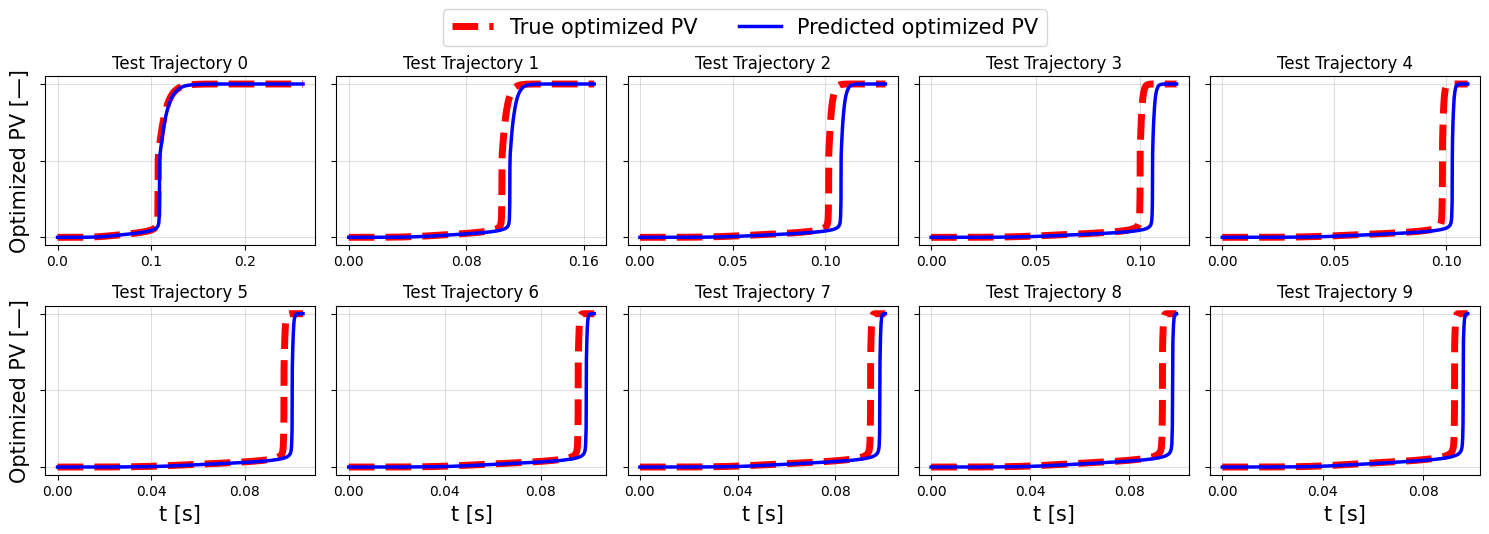

In [ ]:
save = True
zoom = False
pathSave = "C:/Users/admin/Documents/Parente/Figures/2024-PV-optimization/Paper/Results/Autoignition/A posteriori simulations/3.2 - ANN/A posteriori/"


num_test_trajectories = 10
rows, cols = 2, 5  # Arrange in a 2x5 grid

fig, axes = plt.subplots(rows, cols, figsize=(15, 5))  # Define the grid
axes = axes.flatten()  # Flatten to 1D array for easy indexing

for i in range(num_test_trajectories):
    #test state space
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
        test_trajectory = pd.DataFrame(hf[f'test_trajectory_{i}'][:], columns = state_space_names)
        state_space_test_DNS = test_trajectory[state_space_names_DNS].to_numpy()
        PV_optimized_test = PV_model.get_PV(torch.from_numpy(np.delete(state_space_test_DNS, idx_species_removed, axis=1))).detach().numpy()

    #test time trajectories
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}time-test-trajectories.h5", 'r') as hf:
        test_trajectory_time = pd.DataFrame(hf[f'test_trajectory_{i}'][:])
        
    ax = axes[i]

    PV_min = PV_optimized_test[idx_start_simulation:].min()
    PV_max = PV_optimized_test[idx_start_simulation:].max()

    if(zoom):
        ##############################################
        # Get the first and last index of the ignition
        ##############################################

        H2O_array = test_trajectory["H2O"].to_numpy()
        
        max_val = H2O_array.max()
        min_perc = 0.0028
        max_perc = 0.999
        lower_threshold = min_perc * max_val
        upper_threshold = max_perc * max_val

        idx_1 = np.searchsorted(H2O_array, lower_threshold, side='left')
        idx_99 = np.searchsorted(H2O_array, upper_threshold, side='left')

        ax.plot(test_trajectory_time[idx_1:idx_99], -(PV_optimized_test[idx_1:idx_99]-PV_min)/(PV_max - PV_min)+1, label="True optimized PV", color = "red", linestyle = "--", linewidth = 5) #id_end
        ax.plot(test_trajectory_time[idx_1:idx_99], -(list_simulations_optimized[i][idx_1:idx_99,1]-PV_min)/(PV_max - PV_min)+1, label="Predicted optimized PV", color = "blue", linewidth = 2.5) #idx_end-idx_start_simulation
    else:
        ax.plot(test_trajectory_time[idx_start_simulation:], (PV_optimized_test[idx_start_simulation:]-PV_min)/(PV_max - PV_min), label="True optimized PV", color = "red", linestyle = "--", linewidth = 5) #id_end
        ax.plot(test_trajectory_time[idx_start_simulation:], (list_simulations_optimized[i][:,1].detach().numpy()-PV_min)/(PV_max - PV_min), label="Predicted optimized PV", color = "blue", linewidth = 2.5) #idx_end-idx_start_simulation
    
    ax.set_title(f"Test Trajectory {i}")
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=3))
    ax.set_yticks([0, 0.5, 1])
    ax.set_yticklabels([])

    ax.grid(True, linestyle='-', alpha=0.4)

    if(i>=num_test_trajectories-cols):
            ax.set_xlabel(f"t [s]", fontsize = 15)
    
    if(i%cols == 0):
            ax.set_ylabel('Optimized PV [\u2014]', fontsize = 15)    

#hide empty figures
for j in range(num_test_trajectories, len(axes)):
    axes[j].axis("off")

handles, labels = axes[0].get_legend_handles_labels()
custom_handles = [
    Line2D([0], [0], color=handle.get_color(),
           linestyle=handle.get_linestyle(),
           linewidth=handle.get_linewidth(),
           label=label)
    for handle, label in zip(handles, labels)
]
fig.legend(custom_handles, labels, loc='upper center', ncol=2, fontsize=15, frameon=True, bbox_to_anchor=(0.5, 1.08))

name = f"Heuristic vs optimized {id_model} - A posteriori - Optimized PV - ANN {regression_modelname_optimized}{f' - zoom {min_perc}-{max_perc}' if zoom else ''}.png"
namePdf = f"Heuristic vs optimized {id_model} - A posteriori - Optimized PV - ANN {regression_modelname_optimized}{f' - zoom {min_perc}-{max_perc}' if zoom else ''}.pdf"

# Adjust layout
plt.tight_layout()
if(save):
    plt.savefig(pathSave + name, dpi=300, bbox_inches = "tight")
    plt.savefig(pathSave + namePdf, bbox_inches = "tight")
plt.show()

<h3> Run the a posteriori simulation longer

In [ ]:
list_simulations_optimized_ext = []

#Get current date and time
now = datetime.now()
date_str = now.strftime("%Y-%m-%d")
time_str = now.strftime("%Hh%M")

print("Predicted")

for i in range(10):

    with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
        test_trajectory = pd.DataFrame(hf[f'test_trajectory_{i}'][:], columns = state_space_names)
        state_space_test_DNS = test_trajectory[state_space_names_DNS].to_numpy()
        
        PV_optimized_test = PV_model.get_PV(torch.from_numpy(np.delete(state_space_test_DNS, idx_species_removed, axis=1))).detach().numpy()

        f_PV_optimized_test = np.hstack((np.full(PV_optimized_test.shape[0], mixture_fractions_test[i]).reshape(-1,1), PV_optimized_test.reshape(-1,1)))
        f_PV_optimized_test = torch.from_numpy(f_PV_optimized_test).clone().detach()

        
    #test time trajectories
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}time-test-trajectories.h5", 'r') as hf:
        test_trajectory_time = pd.DataFrame(hf[f'test_trajectory_{i}'][:])

    initial_condition = f_PV_optimized_test[0,:]

    t_coordinates = test_trajectory_time[0:].to_numpy().ravel()
    t_coordinates = torch.tensor(t_coordinates)
    deltaTime = t_coordinates[-1] - t_coordinates[-2]

    last_value = t_coordinates[-1]
    new_times = []

    next_time = last_value + deltaTime
    while next_time <= 2:
        new_times.append(next_time.item())
        next_time += deltaTime

    #Add extension to the current tensor
    if new_times:
        extension = torch.tensor(new_times, dtype=torch.float32)
        t_coordinates = torch.cat((t_coordinates, extension))
    
    ODEOptimized_instance = ODEOptimized([PV_optimized_test.min(), PV_optimized_test.max()])
    numerical_solution_optimized = odeint(ODEOptimized_instance, initial_condition, t_coordinates)#, method="rk4")
    list_simulations_optimized_ext.append(numerical_solution_optimized) 

Predicted


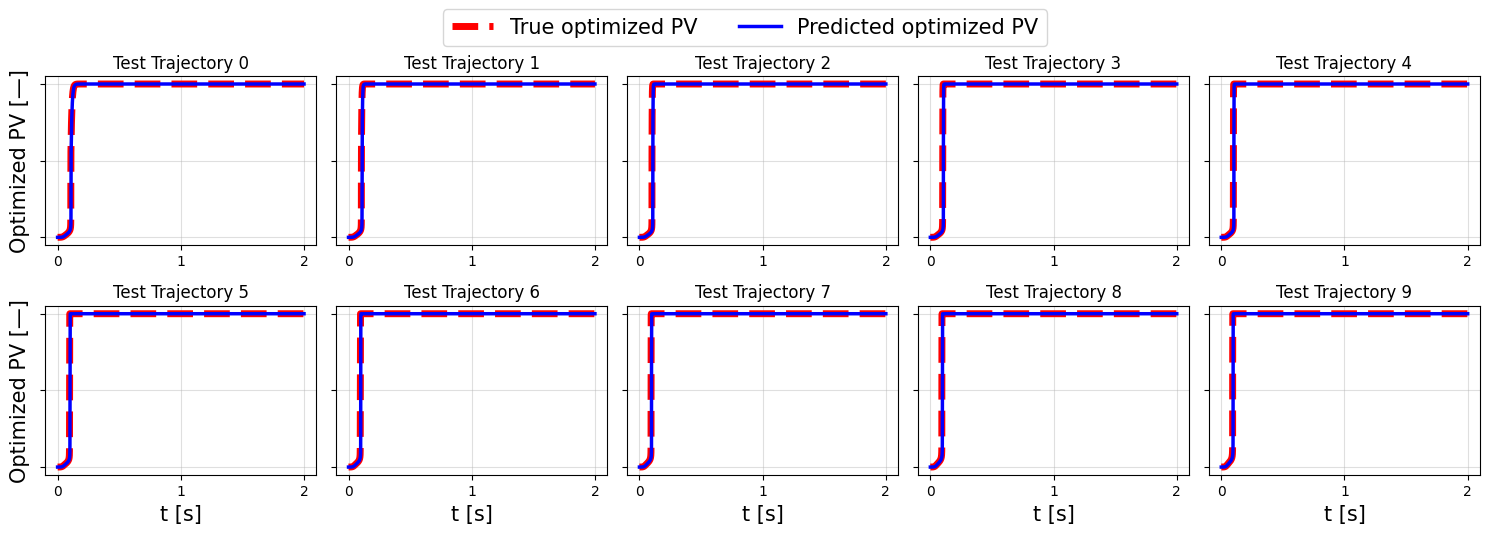

In [22]:
save = True
pathSave = "C:/Users/admin/Documents/Parente/Figures/2024-PV-optimization/Paper/Results/Autoignition/A posteriori simulations/3.2 - ANN/A posteriori/"
name = f"Heuristic vs optimized - A posteriori - Optimized PV - ANN {regression_modelname_optimized}{f' - zoom {min_perc}-{max_perc}' if zoom else ''}_timeExt.png"
namePdf = f"Heuristic vs optimized - A posteriori - Optimized PV - ANN {regression_modelname_optimized}{f' - zoom {min_perc}-{max_perc}' if zoom else ''}_timeExt.pdf"

num_test_trajectories = 10
rows, cols = 2, 5  # Arrange in a 2x5 grid

fig, axes = plt.subplots(rows, cols, figsize=(15, 5))  # Define the grid
axes = axes.flatten()  # Flatten to 1D array for easy indexing

for i in range(10):
    #test state space
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
        test_trajectory = pd.DataFrame(hf[f'test_trajectory_{i}'][:], columns = state_space_names)
        state_space_test_DNS = test_trajectory[state_space_names_DNS].to_numpy()
        PV_optimized_test = PV_model.get_PV(torch.from_numpy(np.delete(state_space_test_DNS, idx_species_removed, axis=1))).detach().numpy()

    #test time trajectories
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}time-test-trajectories.h5", 'r') as hf:
        test_trajectory_time = pd.DataFrame(hf[f'test_trajectory_{i}'][:])
    
    test_trajectory_time = test_trajectory_time.to_numpy().ravel()
    test_trajectory_time = torch.tensor(test_trajectory_time)
    deltaTime = test_trajectory_time[-1] - test_trajectory_time[-2]

    last_value = test_trajectory_time[-1]
    new_times = []

    next_time = last_value + deltaTime
    while next_time <= 2:
        new_times.append(next_time.item())
        next_time += deltaTime

    #Add extension to the current tensor
    if new_times:
        extension = torch.tensor(new_times, dtype=torch.float32)
        test_trajectory_time_ext = torch.cat((test_trajectory_time, extension))

        last_value = PV_optimized_test[-1]
        extension = np.tile(last_value, (len(new_times), 1))  #extension with last value of PV_optimized_test
        PV_optimized_test_ext = np.vstack((PV_optimized_test, extension)) #concatenate the extension with the original value
    
    min_PV = PV_optimized_test.min()
    max_PV = PV_optimized_test.max()
    
    ax = axes[i]
    ax.plot(test_trajectory_time_ext, (PV_optimized_test_ext-min_PV)/(max_PV-min_PV), label="True optimized PV", color = "red", linestyle = "--", linewidth = 5) #id_end
    ax.plot(test_trajectory_time_ext, (list_simulations_optimized_ext[i].squeeze()[:,1].detach().numpy()-min_PV)/(max_PV-min_PV), label="Predicted optimized PV", color = "blue", linewidth = 2.5) #idx_end-idx_start_simulation
    ax.set_title(f"Test Trajectory {i}")
    #ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=3))
    ax.set_xticks([0, 1 , 2])
    #ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=3))
    ax.set_yticks([0, 0.5, 1])
    ax.set_yticklabels([])

    ax.grid(True, linestyle='-', alpha=0.4)

    if(i>=num_test_trajectories-cols):
            ax.set_xlabel(f"t [s]", fontsize = 15)
    
    if(i%cols == 0):
            ax.set_ylabel('Optimized PV [\u2014]', fontsize = 15)    

#hide empty figures
for j in range(num_test_trajectories, len(axes)):
    axes[j].axis("off")

handles, labels = axes[0].get_legend_handles_labels()
custom_handles = [
    Line2D([0], [0], color=handle.get_color(),
           linestyle=handle.get_linestyle(),
           linewidth=handle.get_linewidth() * 1,  # Increase legend linewidth
           label=label)
    for handle, label in zip(handles, labels)
]
fig.legend(custom_handles, labels, loc='upper center', ncol=2, fontsize=15, frameon=True, bbox_to_anchor=(0.5, 1.08))

# Adjust layout
plt.tight_layout()
if(save):
    plt.savefig(pathSave + name, dpi=300, bbox_inches = "tight")
    plt.savefig(pathSave + namePdf, bbox_inches = "tight")
plt.show()

In [18]:
def ignition_time_difference(time_array, pv_true, pv_pred, threshold=0.99):
    """
    Compute the time difference between true and predicted PV ignition times.
    
    Parameters
    ----------
    time_array : np.ndarray
        1D array of time values.
    pv_true : np.ndarray
        1D array of true PV values (same length as time_array).
    pv_pred : np.ndarray
        1D array of predicted PV values (same length as time_array).
    threshold : float, optional
        The PV threshold for ignition (default: 0.99).
    
    Returns
    -------
    float or None
        The time difference (predicted - true) when both trajectories reach
        the threshold. Returns None if either trajectory never reaches it.
    """
    # Find first index where true PV >= threshold
    true_idx = np.argmax(pv_true >= threshold) if np.any(pv_true >= threshold) else None
    # Find first index where predicted PV >= threshold
    pred_idx = np.argmax(pv_pred >= threshold) if np.any(pv_pred >= threshold) else None

    if true_idx is None or pred_idx is None:
        return None  # one of them never reaches threshold

    true_time = time_array[true_idx]
    pred_time = time_array[pred_idx]

    return np.round(pred_time - true_time, 3)

for i in range(10):
    #test state space
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
        test_trajectory = pd.DataFrame(hf[f'test_trajectory_{i}'][:], columns = state_space_names)
        state_space_test_DNS = test_trajectory[state_space_names_DNS].to_numpy()
        PV_optimized_test = PV_model.get_PV(torch.from_numpy(np.delete(state_space_test_DNS, idx_species_removed, axis=1))).detach().numpy()
    
    #test time trajectories
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}time-test-trajectories.h5", 'r') as hf:
        test_trajectory_time = pd.DataFrame(hf[f'test_trajectory_{i}'][:])
    
    test_trajectory_time = test_trajectory_time.to_numpy().ravel()
    test_trajectory_time = torch.tensor(test_trajectory_time)
    deltaTime = test_trajectory_time[-1] - test_trajectory_time[-2]

    last_value = test_trajectory_time[-1]
    new_times = []

    next_time = last_value + deltaTime
    while next_time <= 2:
        new_times.append(next_time.item())
        next_time += deltaTime

    #Add extension to the current tensor
    if new_times:
        extension = torch.tensor(new_times, dtype=torch.float32)
        test_trajectory_time_ext = torch.cat((test_trajectory_time, extension))

        last_value = PV_optimized_test[-1]
        extension = np.tile(last_value, (len(new_times), 1))  #extension with last value of PV_Xu_test
        PV_optimized_test_ext = np.vstack((PV_optimized_test, extension)) #concatenate the extension with the original value

    min_PV = PV_optimized_test_ext.min()
    max_PV = PV_optimized_test_ext.max()

    true_PV_norm = (PV_optimized_test_ext - min_PV) / (max_PV - min_PV)
    pred_PV_norm = (list_simulations_optimized_ext[i].squeeze()[:,1].detach().numpy() - min_PV) / (max_PV - min_PV)

    # Compute ignition time difference
    dt = ignition_time_difference(np.array(test_trajectory_time_ext), true_PV_norm, pred_PV_norm)
    print(f"Ignition time difference of traj {i}:", dt, "s")

Ignition time difference of traj 0: 0.002 s
Ignition time difference of traj 1: 0.005 s
Ignition time difference of traj 2: 0.007 s
Ignition time difference of traj 3: 0.006 s
Ignition time difference of traj 4: 0.005 s
Ignition time difference of traj 5: 0.004 s
Ignition time difference of traj 6: 0.003 s
Ignition time difference of traj 7: 0.004 s
Ignition time difference of traj 8: 0.004 s
Ignition time difference of traj 9: 0.004 s


## Figure for paper: A posteriori - PV trajectory

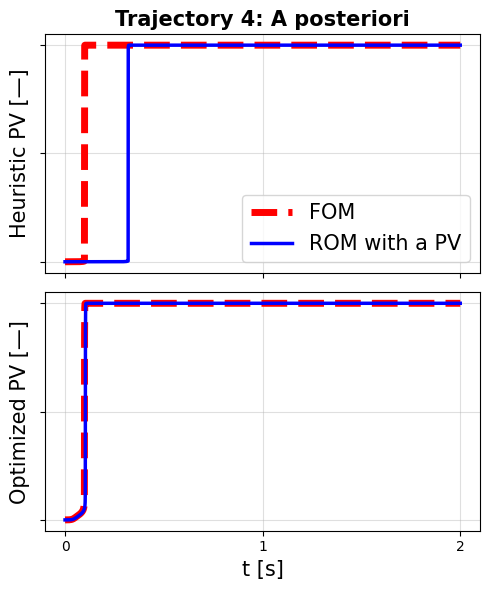

In [88]:
save = True
pathSave = "C:/Users/admin/Documents/Parente/Figures/2024-PV-optimization/Paper/Results/Autoignition/A posteriori simulations/3.2 - ANN/A posteriori/"
name = f"Heuristic vs optimized - A posteriori - both PVs - ANN - timeExt - PAPER.png"
namePDF = f"Heuristic vs optimized - A posteriori - both PVs - ANN - timeExt - PAPER.pdf"

num_test_trajectories = 10
rows, cols = 2, 5  # Arrange in a 2x5 grid

fig, axes = plt.subplots(2, 1, figsize=(5, 6))  # 2 rows, 1 column
ax1, ax2 = axes

i = 4

#-------------------------
# Heuristic PV
#-------------------------

#test state space
with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
    test_trajectory = pd.DataFrame(hf[f'test_trajectory_{i}'][:], columns = state_space_names)
    if(Xu_H2O == "H2O"):
        PV_Xu_test = test_trajectory["H2O"]
    elif(Xu_H2O == "Xu"):
        PV_Xu_test = test_trajectory["H2O"] - test_trajectory["H2"] - test_trajectory["O2"]
    PV_Xu_test = PV_Xu_test.to_numpy().reshape(-1,1)
    #PV_Xu_test = (PV_Xu_test - PV_Xu_min_train)/(PV_Xu_max_train - PV_Xu_min_train)
    f_PV_Xu_test = np.hstack((np.full(PV_Xu_test.shape[0], mixture_fractions_test[i]).reshape(-1,1), PV_Xu_test))

#test time trajectories
with h5py.File(f"{path_data_autoignition}{filename_autoignition}time-test-trajectories.h5", 'r') as hf:
    test_trajectory_time = pd.DataFrame(hf[f'test_trajectory_{i}'][:])

test_trajectory_time = test_trajectory_time.to_numpy().ravel()
test_trajectory_time = torch.tensor(test_trajectory_time)
deltaTime = test_trajectory_time[-1] - test_trajectory_time[-2]

last_value = test_trajectory_time[-1]
new_times = []

next_time = last_value + deltaTime
while next_time <= 2:
    new_times.append(next_time.item())
    next_time += deltaTime

#Add extension to the current tensor
if new_times:
    extension = torch.tensor(new_times, dtype=torch.float32)
    test_trajectory_time_ext = torch.cat((test_trajectory_time, extension))

    last_value = PV_Xu_test[-1]
    extension = np.tile(last_value, (len(new_times), 1))  #extension with last value of PV_Xu_test
    PV_Xu_test_ext = np.vstack((PV_Xu_test, extension)) #concatenate the extension with the original value

min_PV = PV_Xu_test_ext.min()
max_PV = PV_Xu_test_ext.max()

ax1.plot(test_trajectory_time_ext, (PV_Xu_test_ext-min_PV)/(max_PV - min_PV), label="FOM", color = "red", linestyle = "--", linewidth = 5)
ax1.plot(test_trajectory_time_ext, (list_simulations_Xu_ext[i][:,1].detach().numpy()-min_PV)/(max_PV - min_PV), label="ROM with a PV", color = "blue", linewidth = 2.5)
ax1.set_title(f"Trajectory {i}: A posteriori", fontsize = 15, fontweight = "bold")
ax1.set_xticks([0, 1, 2])
ax1.set_xticklabels([])
#ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=4))
ax1.set_yticks([0, 0.5, 1])
ax1.set_yticklabels([])
ax1.grid(True, linestyle='-', alpha=0.4)

ax1.set_ylabel('Heuristic PV [\u2014]', fontsize = 15)

ax1.legend(ncol=1, fontsize=15, loc = "lower right")




#-------------------------
# Optimized PV
#-------------------------

#test state space
with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
    test_trajectory = pd.DataFrame(hf[f'test_trajectory_{i}'][:], columns = state_space_names)
    state_space_test_DNS = test_trajectory[state_space_names_DNS].to_numpy()
    PV_optimized_test = PV_model.get_PV(torch.from_numpy(np.delete(state_space_test_DNS, idx_species_removed, axis=1))).detach().numpy()

#test time trajectories
with h5py.File(f"{path_data_autoignition}{filename_autoignition}time-test-trajectories.h5", 'r') as hf:
    test_trajectory_time = pd.DataFrame(hf[f'test_trajectory_{i}'][:])

test_trajectory_time = test_trajectory_time.to_numpy().ravel()
test_trajectory_time = torch.tensor(test_trajectory_time)
deltaTime = test_trajectory_time[-1] - test_trajectory_time[-2]

last_value = test_trajectory_time[-1]
new_times = []

next_time = last_value + deltaTime
while next_time <= 2:
    new_times.append(next_time.item())
    next_time += deltaTime

#Add extension to the current tensor
if new_times:
    extension = torch.tensor(new_times, dtype=torch.float32)
    test_trajectory_time_ext = torch.cat((test_trajectory_time, extension))

    last_value = PV_optimized_test[-1]
    extension = np.tile(last_value, (len(new_times), 1))  #extension with last value of PV_optimized_test
    PV_optimized_test_ext = np.vstack((PV_optimized_test, extension)) #concatenate the extension with the original value

min_PV = PV_optimized_test.min()
max_PV = PV_optimized_test.max()

ax2.plot(test_trajectory_time_ext, (PV_optimized_test_ext-min_PV)/(max_PV-min_PV), label="True optimized PV", color = "red", linestyle = "--", linewidth = 5) #id_end
ax2.plot(test_trajectory_time_ext, (list_simulations_optimized_ext[i].squeeze()[:,1].detach().numpy()-min_PV)/(max_PV-min_PV), label="Predicted optimized PV", color = "blue", linewidth = 2.5) #idx_end-idx_start_simulation
#ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=3))
ax2.set_xticks([0, 1 , 2])
#ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=3))
ax2.set_yticks([0, 0.5, 1])
ax2.set_yticklabels([])

ax2.grid(True, linestyle='-', alpha=0.4)

ax2.set_xlabel(f"t [s]", fontsize = 15)
    
ax2.set_ylabel('Optimized PV [\u2014]', fontsize = 15)    


# Adjust layout
plt.tight_layout()
if(save):
    plt.savefig(pathSave + name, dpi=1000, bbox_inches = "tight")
    plt.savefig(pathSave + namePDF, bbox_inches = "tight")
plt.show()

<h3> Reconstruction to the full state space

In [23]:
#Load the model

with open(f'{path_regression_model}{regression_full_modelname_optimized}_metadata.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)
model_params = loaded_dict["model_params"]

mins_input_full_optimized = loaded_dict["mins_input"]
maxs_input_full_optimized = loaded_dict["maxs_input"]
mins_output_full_optimized = loaded_dict["mins_output"]
maxs_output_full_optimized = loaded_dict["maxs_output"]

neuron_layers = loaded_dict["neuron_layers"]
max_epo = loaded_dict["max_epo"]

model_regression_full_optimized = ANN_regression(**model_params)
model_regression_full_optimized.load_state_dict(torch.load(f"{path_regression_model}{regression_full_modelname_optimized}_model.pth", weights_only=False))

Output_species = loaded_dict["Output_species"]

for i in range(10):
    f_PV_array = list_simulations_optimized[i][:].clone()
    f_PV_array_scaled = (f_PV_array - mins_input_full_optimized)/(maxs_input_full_optimized - mins_input_full_optimized) - 0.5
    prediction_optimized = model_regression_full_optimized(f_PV_array_scaled)

<h3> Comparison of the PV of Xu with the optimized PV

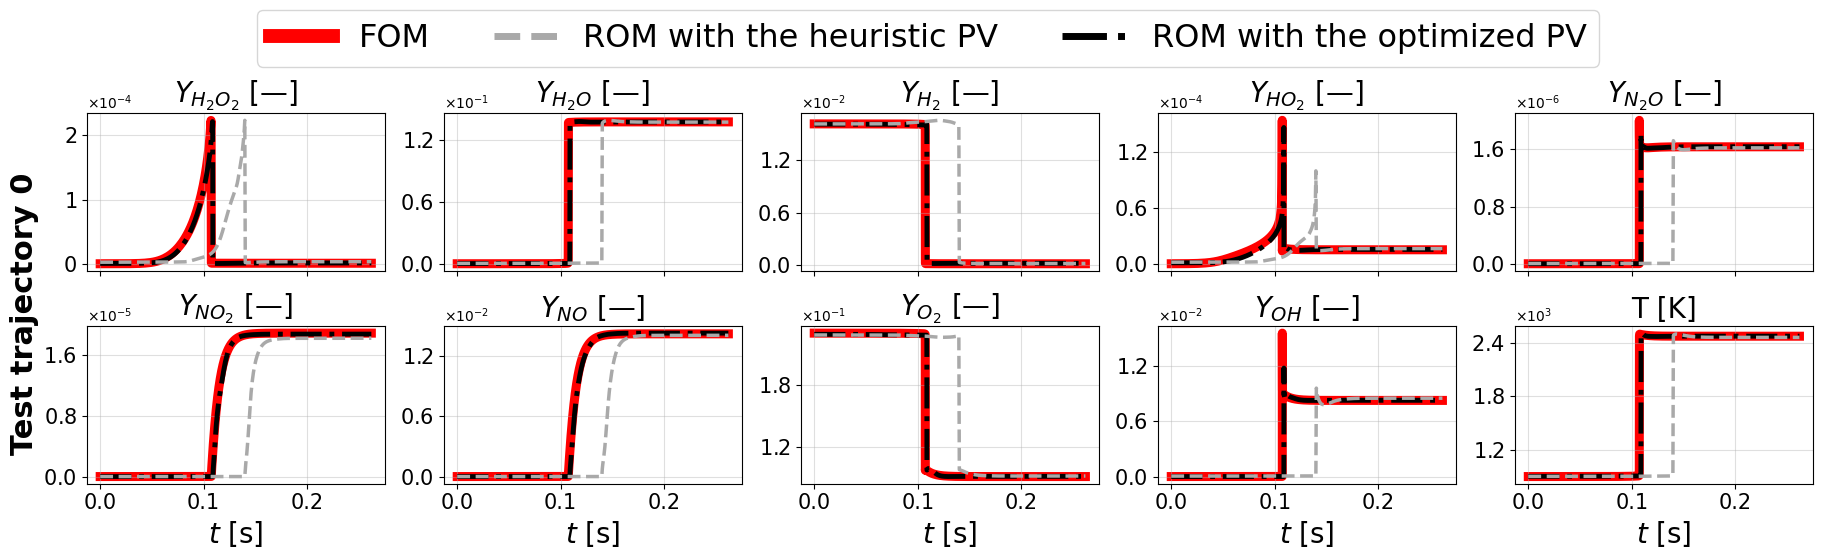

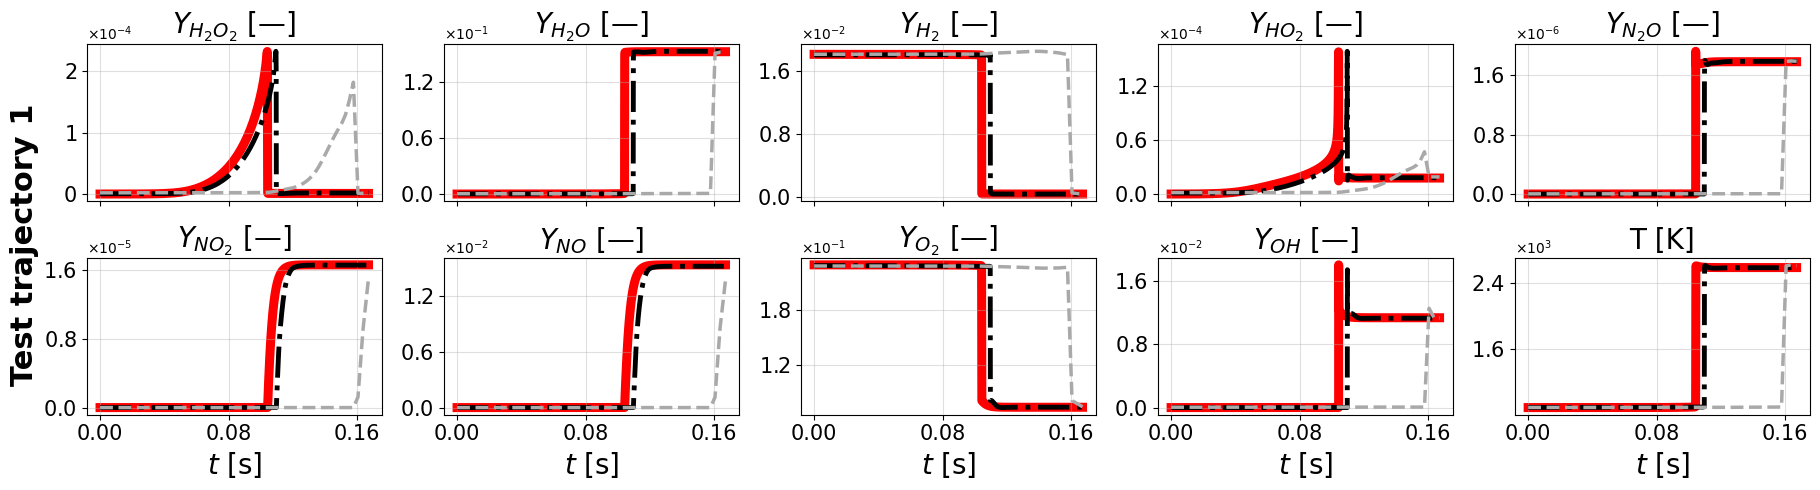

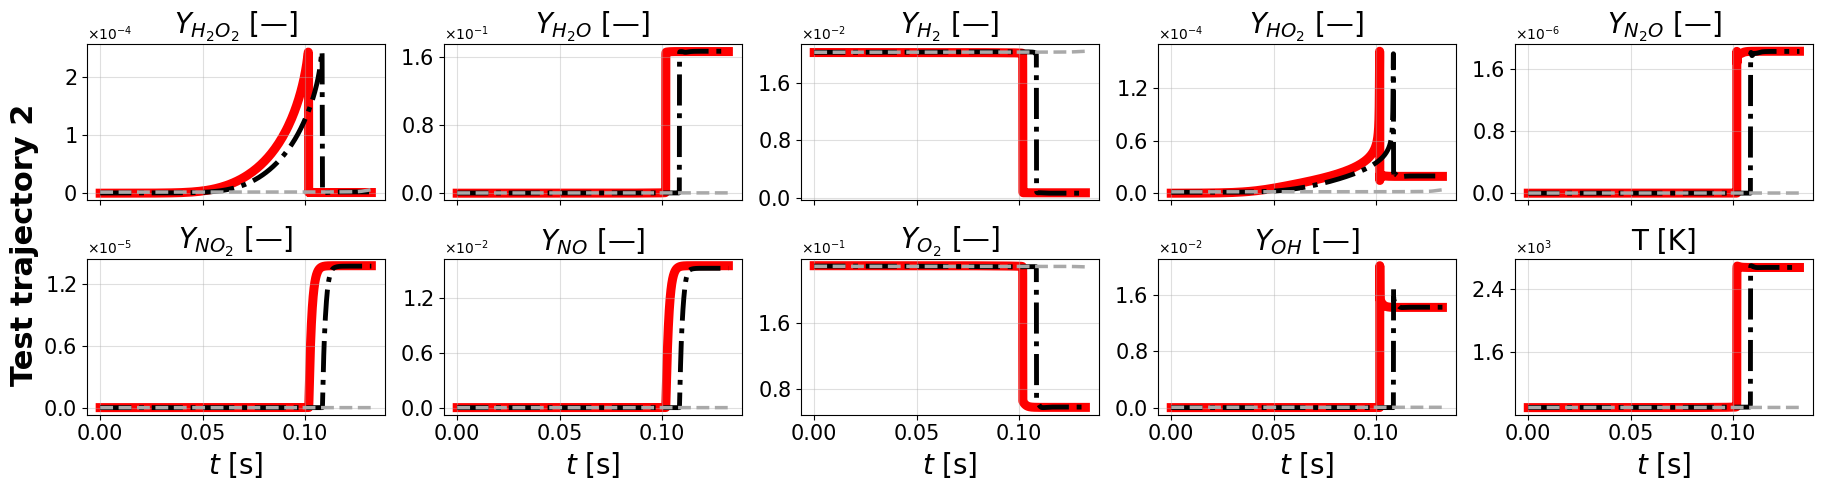

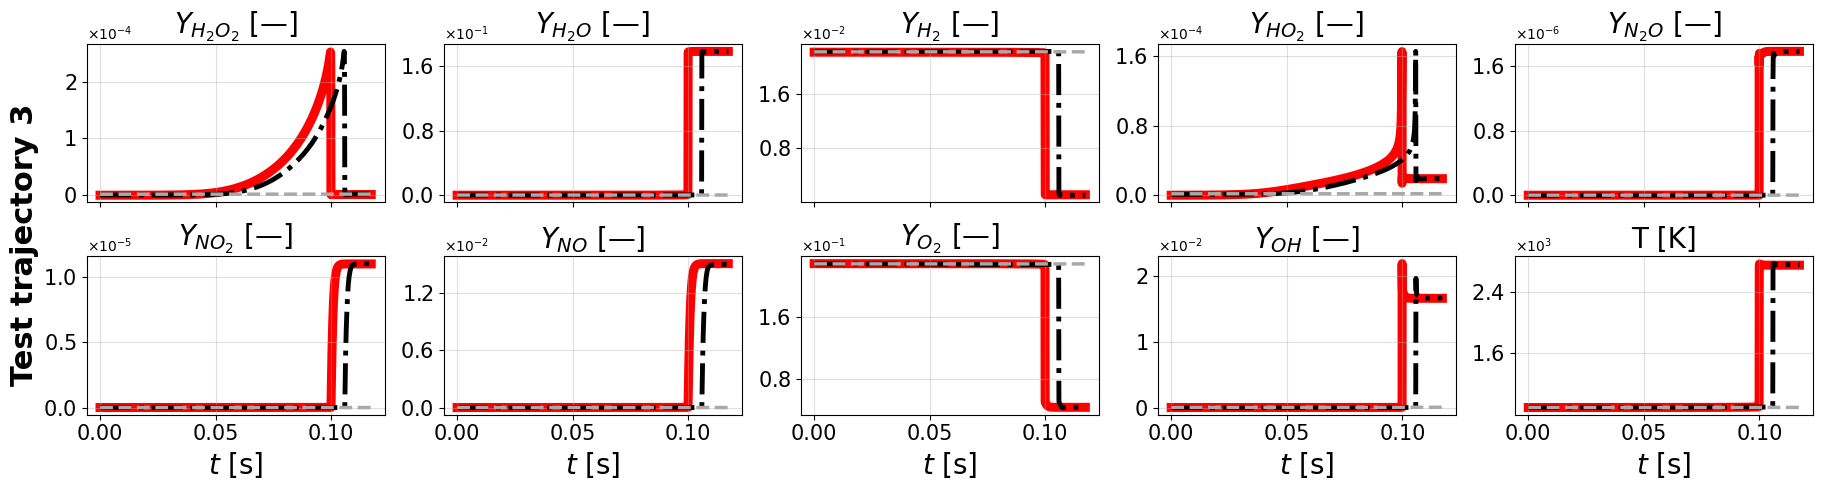

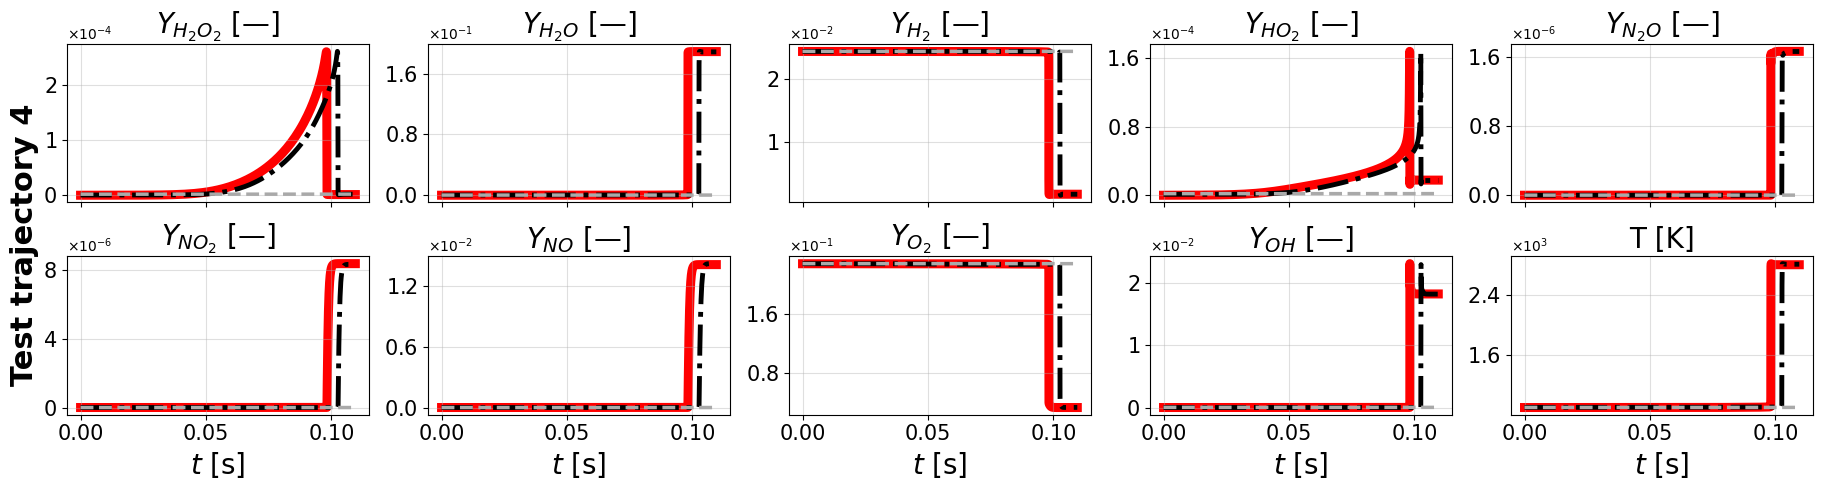

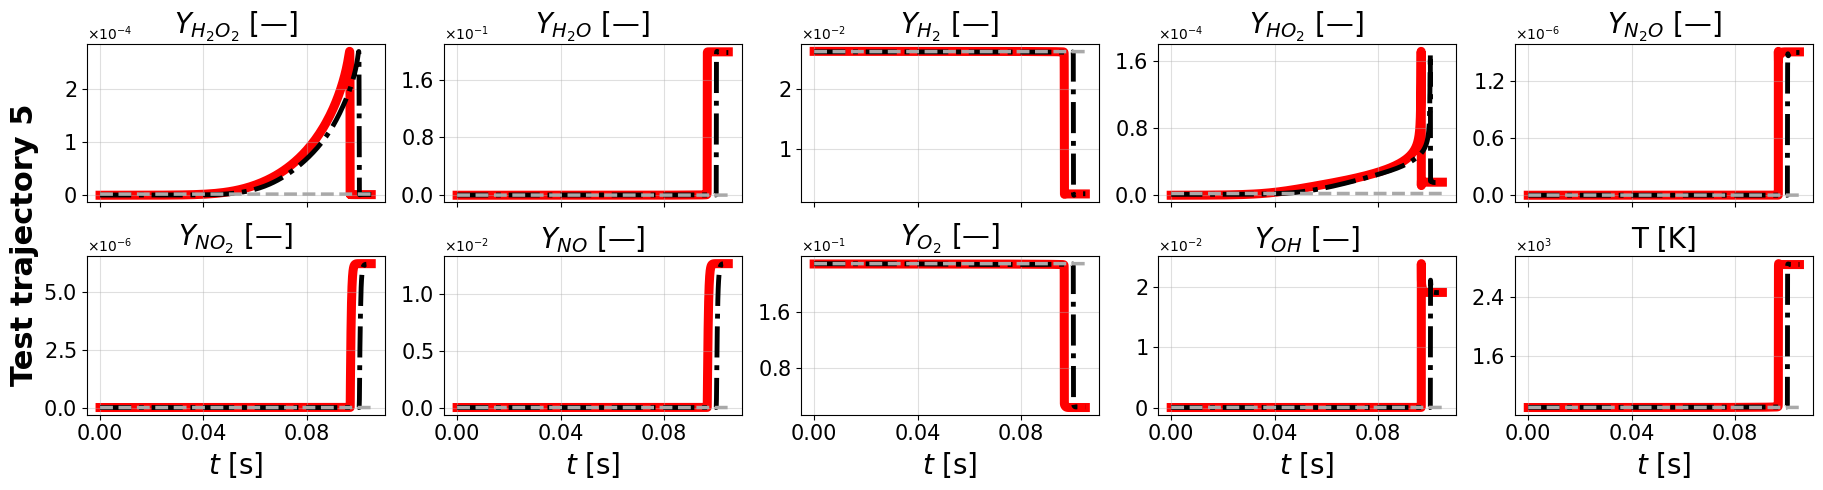

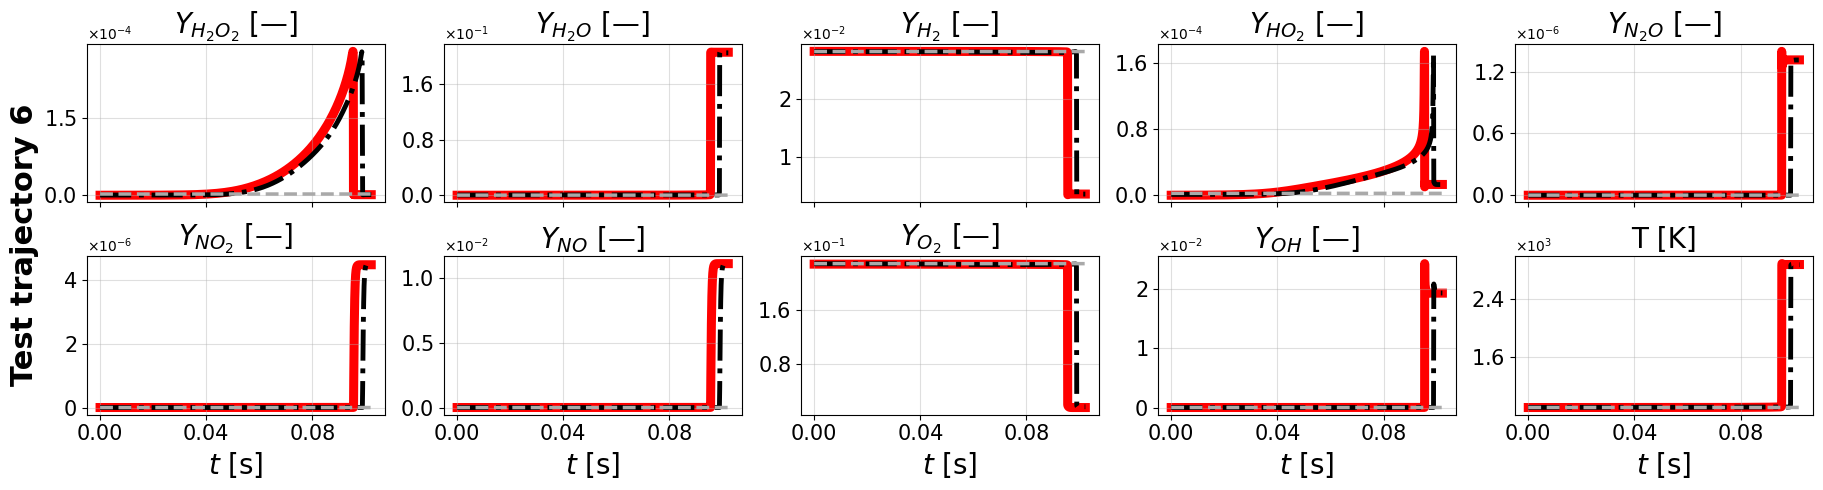

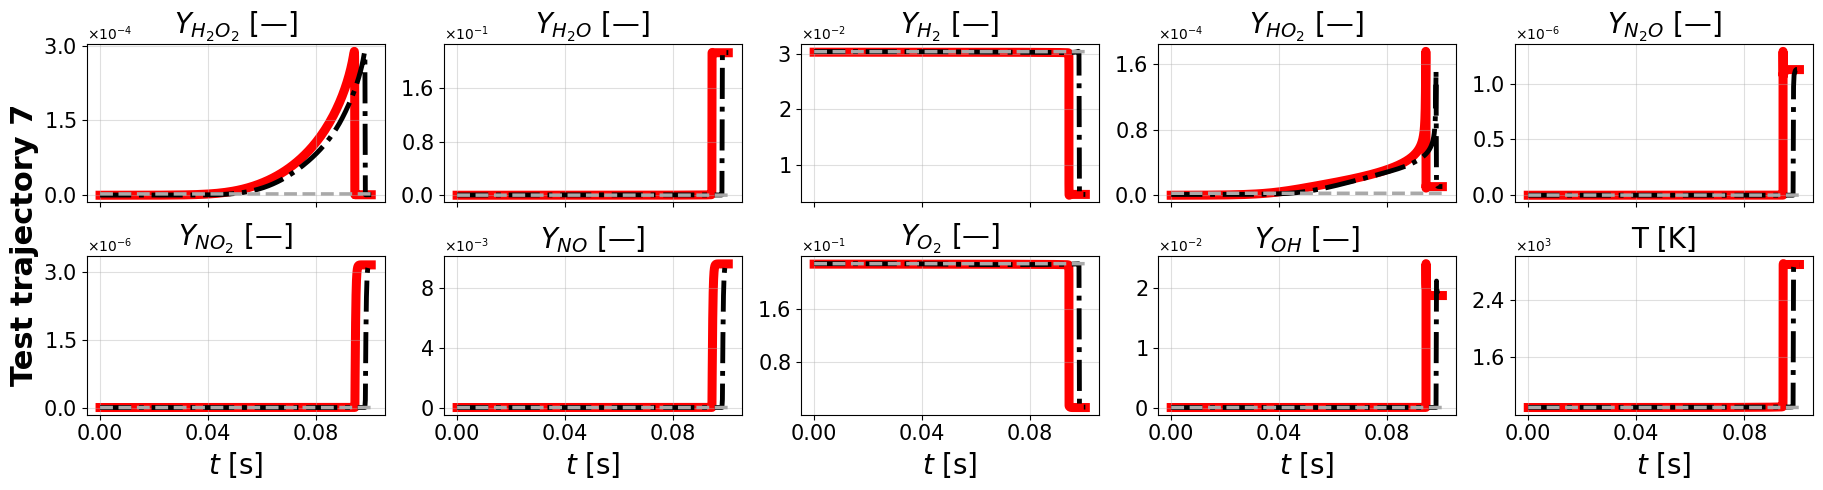

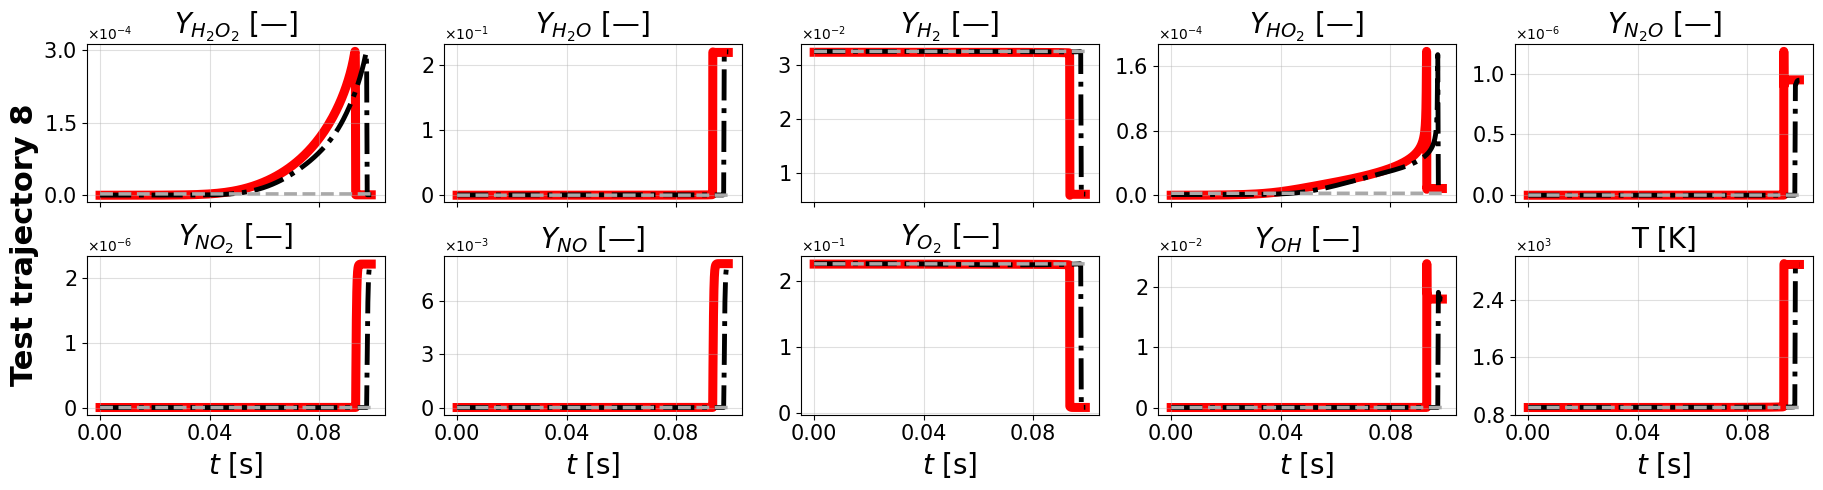

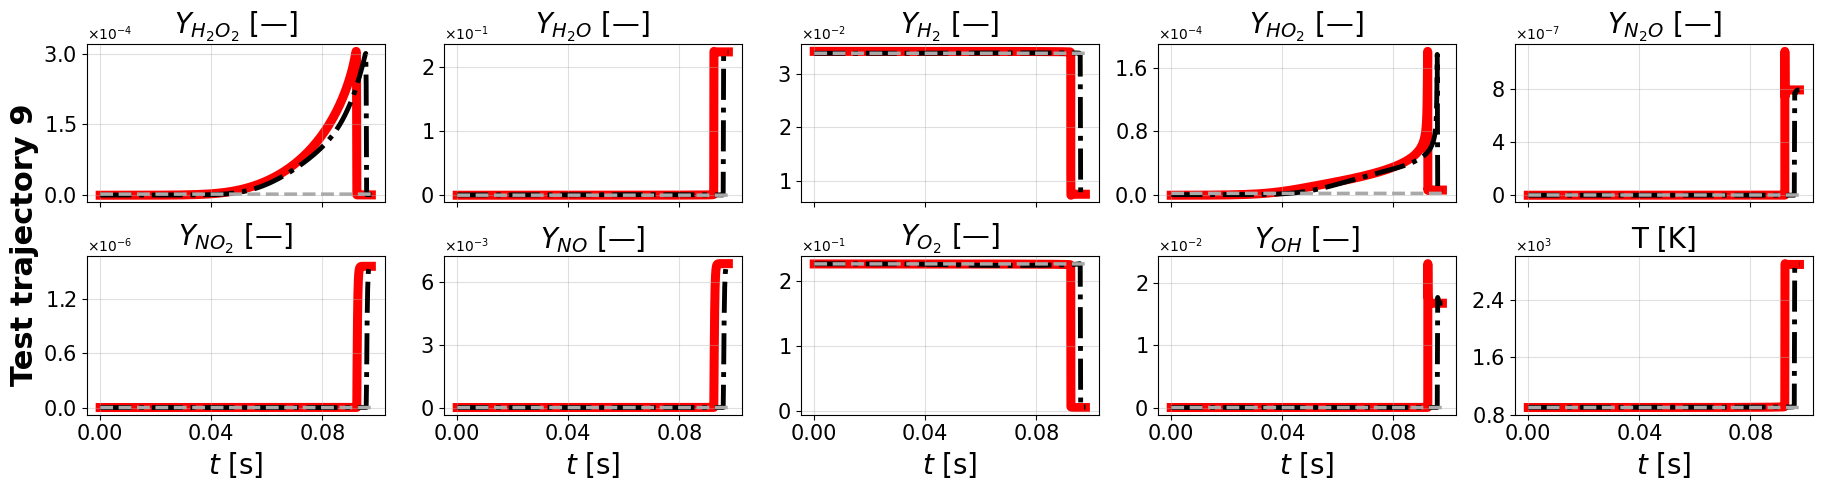

In [24]:
save = True
pathSave = "C:/Users/admin/Documents/Parente/Figures/2024-PV-optimization/Paper/Results/Autoignition/A posteriori simulations/3.2 - ANN/A posteriori/Simulations/"
name = f"Heuristic vs optimized {id_model} - A posteriori - ANN"

Output_species_Latex = [species.replace('2', '_2') for species in Output_species]

for idxSimulation in range(num_test_trajectories):

    rows, cols = 2, 5

    fig, axes = plt.subplots(rows, cols, figsize=(18, 5))
    axes = axes.flatten()

    with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
            test_trajectory = pd.DataFrame(hf[f'test_trajectory_{idxSimulation}'][:], columns = state_space_names)
    #test time trajectories
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}time-test-trajectories.h5", 'r') as hf:
        test_trajectory_time = pd.DataFrame(hf[f'test_trajectory_{idxSimulation}'][:])
    
    for idxQoI in range(len(Output_species)): 
      ax = axes[idxQoI]

      prediction_Xu = (model_regression_full_Xu((list_simulations_Xu[idxSimulation][:]-mins_input_full_Xu)/(maxs_input_full_Xu-mins_input_full_Xu) - 0.5) + 1) /2 * (maxs_output_full_Xu - mins_output_full_Xu) + mins_output_full_Xu
      prediction_Xu = prediction_Xu.detach().numpy()

      prediction_optimized = (model_regression_full_optimized((list_simulations_optimized[idxSimulation][:]-mins_input_full_optimized)/(maxs_input_full_optimized-mins_input_full_optimized) - 0.5) + 1) /2 * (maxs_output_full_optimized - mins_output_full_optimized) + mins_output_full_optimized
      prediction_optimized = prediction_optimized.detach().numpy()
      
      ax.plot(test_trajectory_time, test_trajectory[Output_species[idxQoI]], label = "FOM", c="red", linestyle="-", linewidth=6.5, zorder = 1)  # True trajectory
      ax.plot(test_trajectory_time, prediction_Xu[:, idxQoI], label = "ROM with the heuristic PV", c="darkgrey", linestyle="--", linewidth=2.5, zorder = 3)
      ax.plot(test_trajectory_time, prediction_optimized[:, idxQoI], label = "ROM with the optimized PV", c="k", linestyle="dashdot", linewidth=3.5, zorder = 2)
      
      if(Output_species[idxQoI] == "T"):
        ax.set_title(f"T [K]", fontsize = 20)
      else:
         ax.set_title(f"$Y_{{{Output_species_Latex[idxQoI]}}}$ [\u2014]", fontsize = 20)


      ax.tick_params(axis='x', labelsize=15) 
      ax.tick_params(axis='y', labelsize=15)

      ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=3))
      ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=3))
      if(idxQoI>= num_test_trajectories-cols):
        ax.set_xlabel(f"$t$ [s]", fontsize = 20)
        
      else:
        ax.set_xticklabels([])
      
      formatter = ScalarFormatter(useMathText=True)
      formatter.set_powerlimits((0, 0))
      ax.yaxis.set_major_formatter(formatter)
      ax.grid(True, linestyle='-', alpha=0.4)
          
    for j in range(len(Output_species), len(axes)): #disables axes of plots not used
      axes[j].axis("off")
    
    handles, labels = axes[0].get_legend_handles_labels()
    legend_handles = [
        Line2D([0], [0], color='red', linestyle='-', linewidth=10, label='FOM'),
        Line2D([0], [0], color='darkgrey', linestyle='--', linewidth=5, label='ROM with the heuristic PV'),
        Line2D([0], [0], color='k', linestyle='dashdot', linewidth=5, label='ROM with the optimized PV'),
    ]
    if(idxSimulation == 0):
       
      fig.legend(legend_handles, labels,
                  loc='upper center', 
                  bbox_to_anchor=(0.5, 1.14), 
                  ncol=3, 
                  fontsize=23,
                  frameon=True
              )
    
    fig.text(-0.01, 0.5, f"Test trajectory {idxSimulation}", va='center', rotation='vertical', fontsize=22, fontweight='bold')

    plt.tight_layout() #h_pad = 0

    if(save):
        plt.savefig(f"{pathSave}{name}_testTraj{idxSimulation}.png", dpi=300, bbox_inches="tight")
        plt.savefig(f"{pathSave}{name}_testTraj{idxSimulation}.pdf", bbox_inches="tight")

    if(i==0):
        plt.show()

### Same simulations with extended simulation time to reach equilibrium and visualize the ignition of the heuristic PV

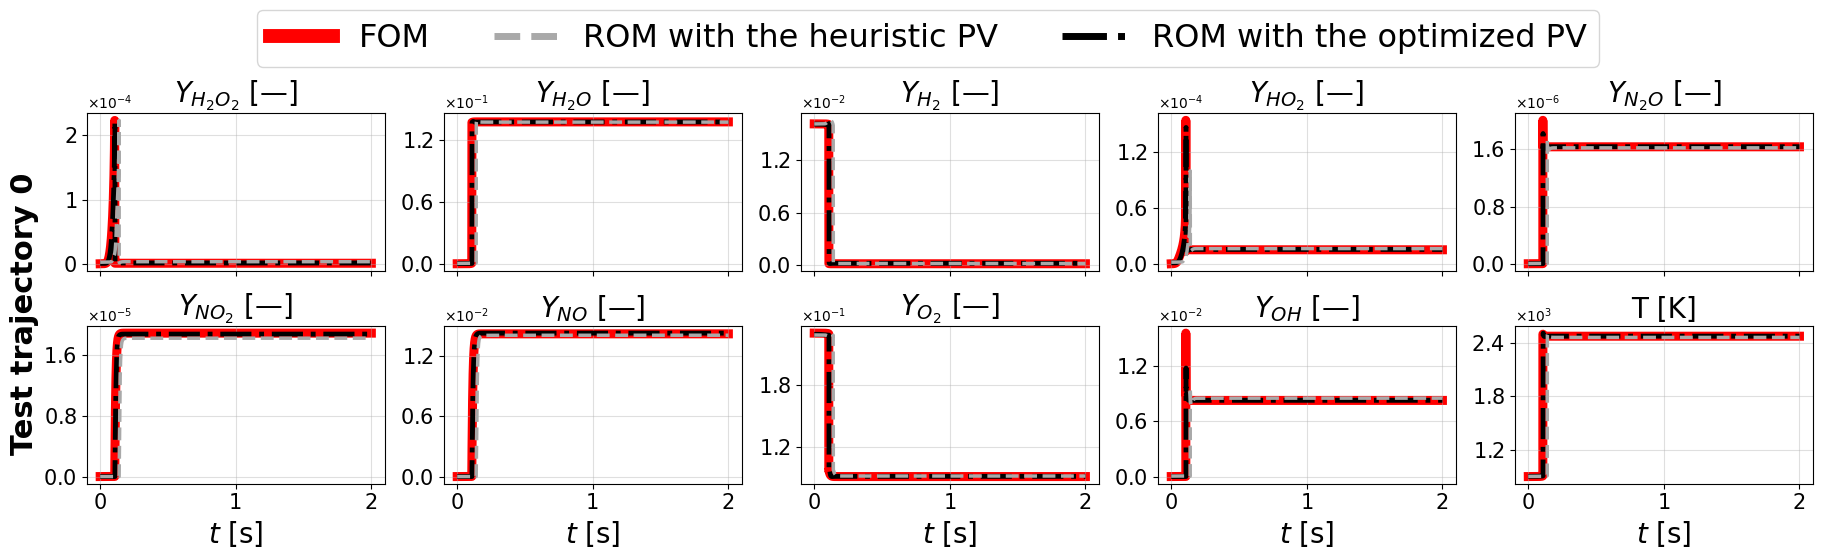

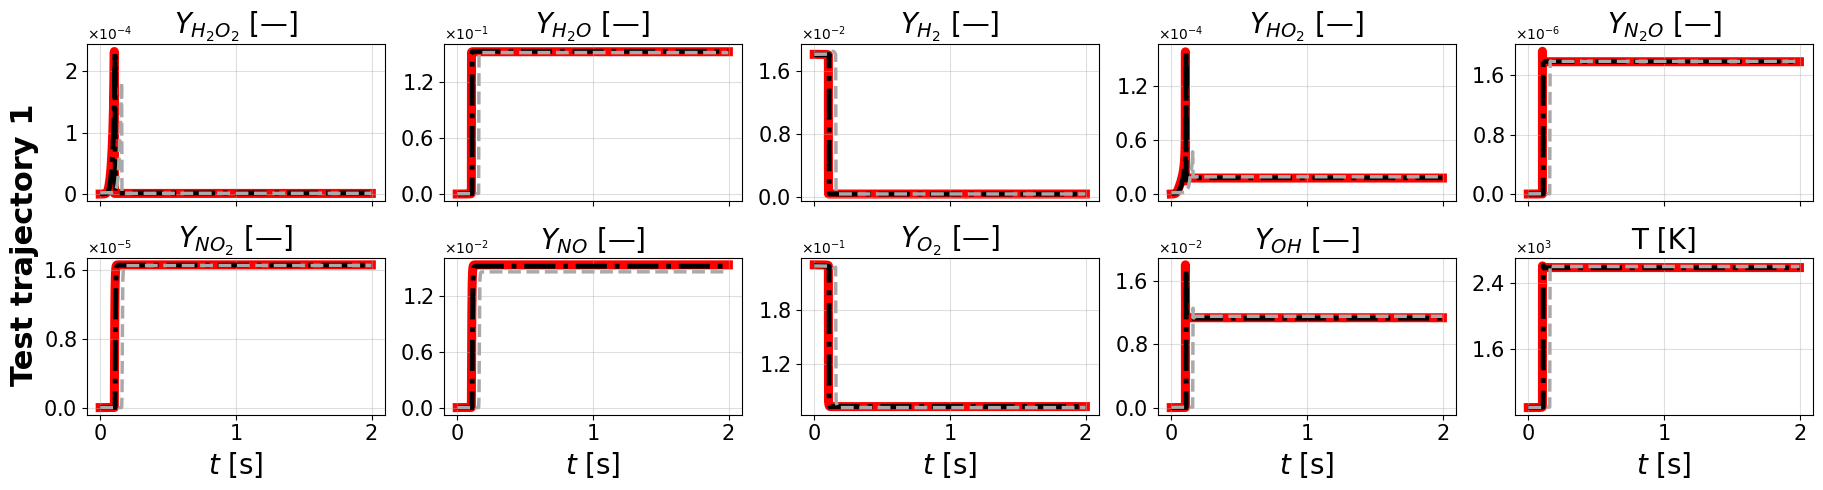

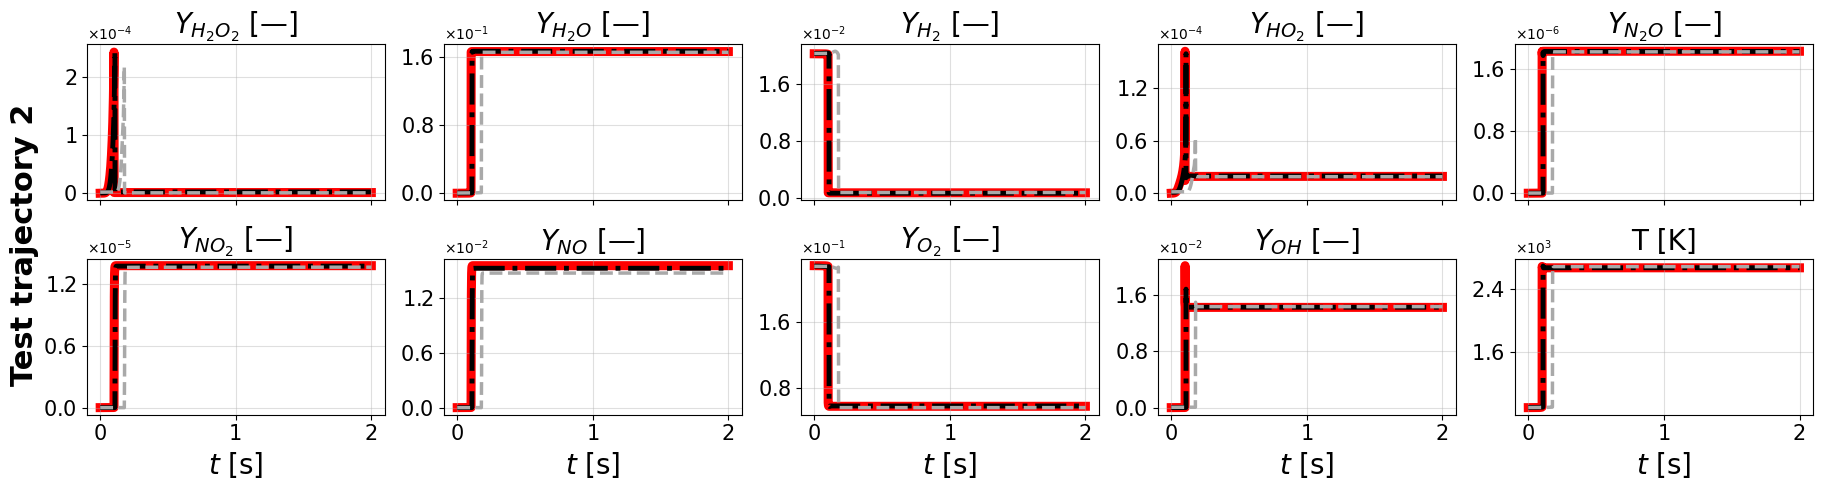

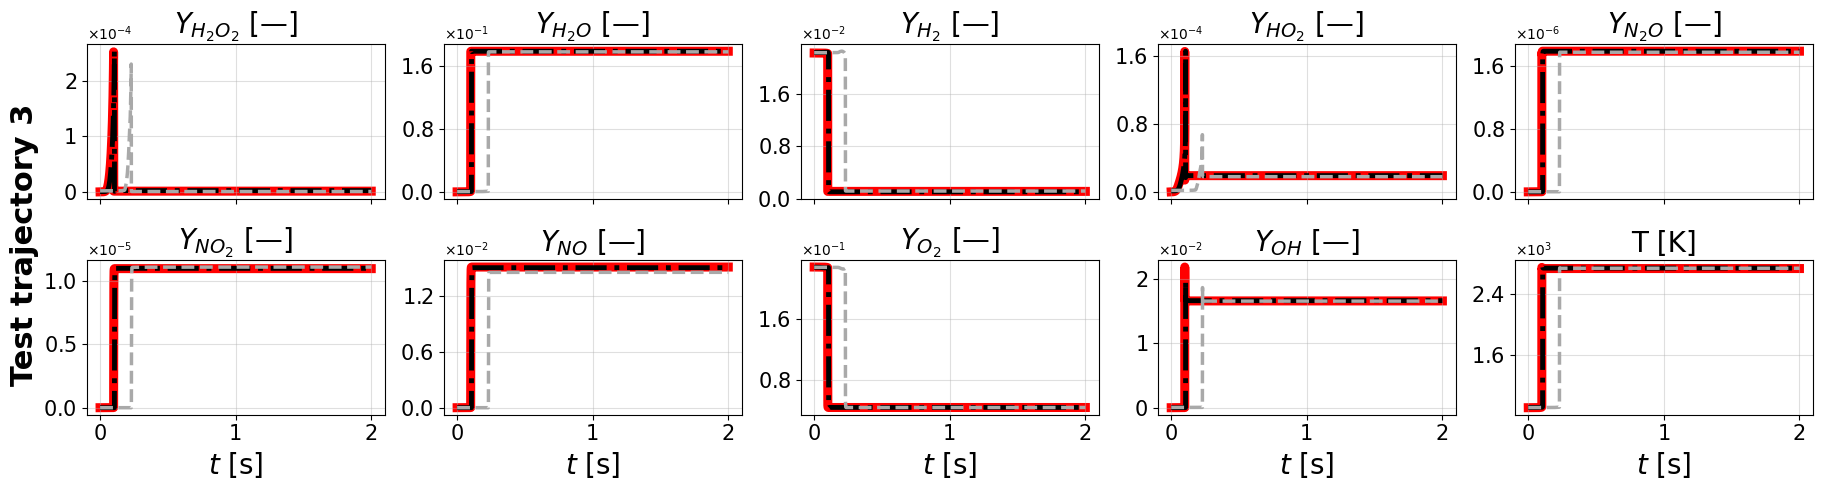

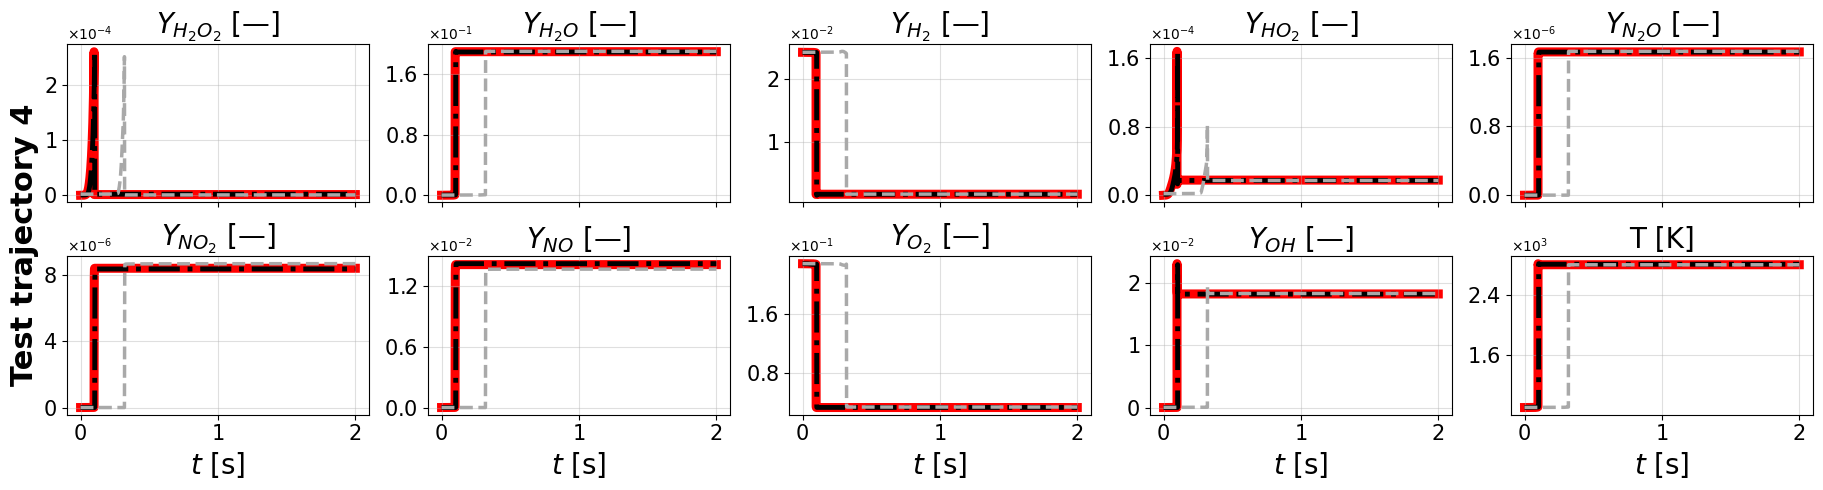

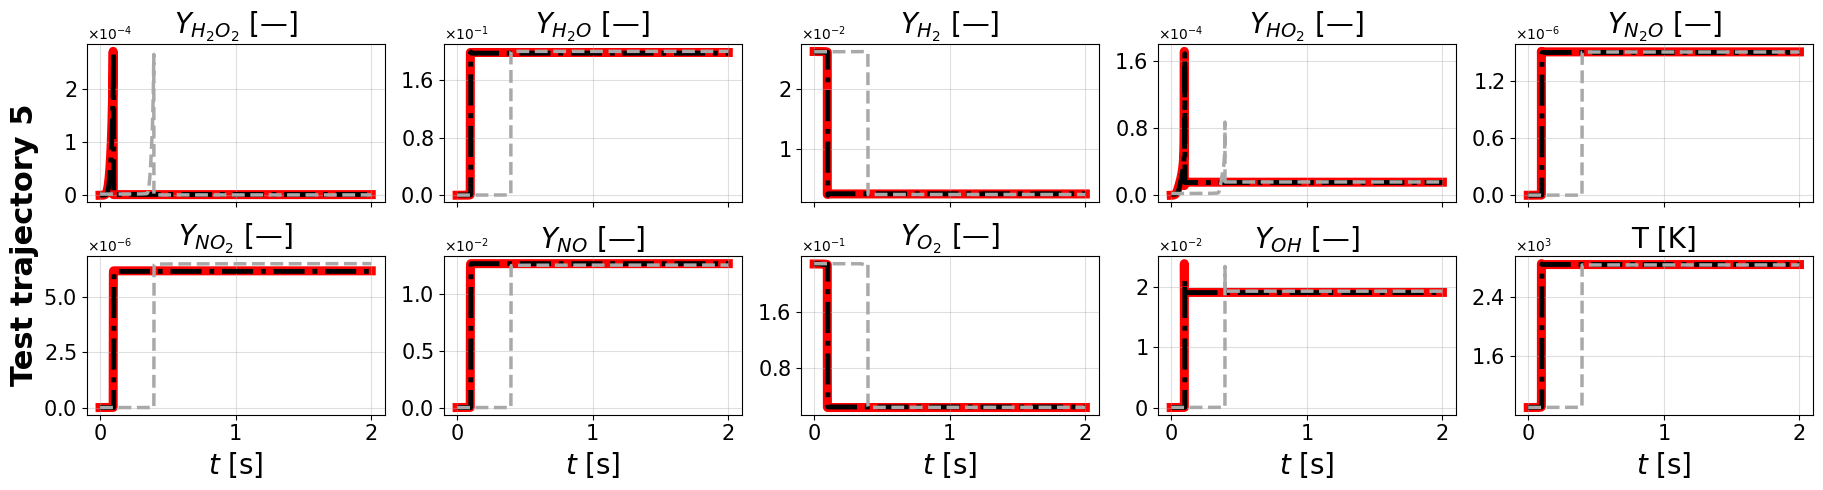

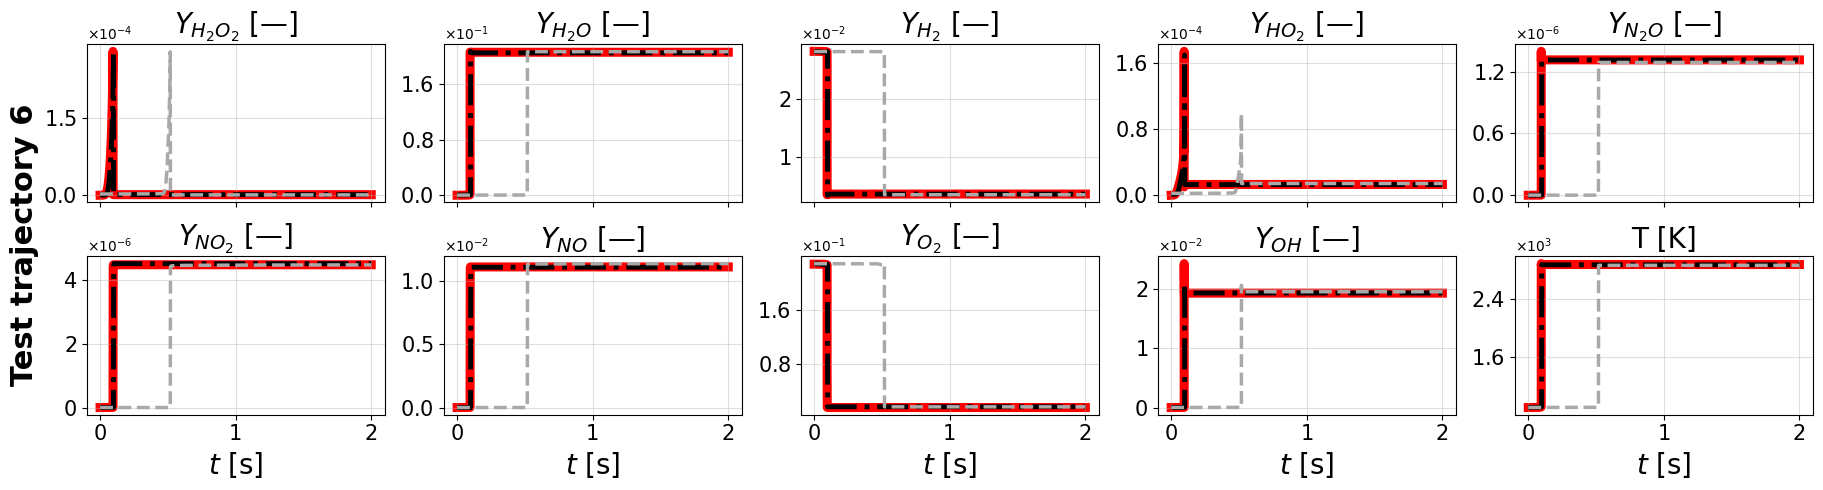

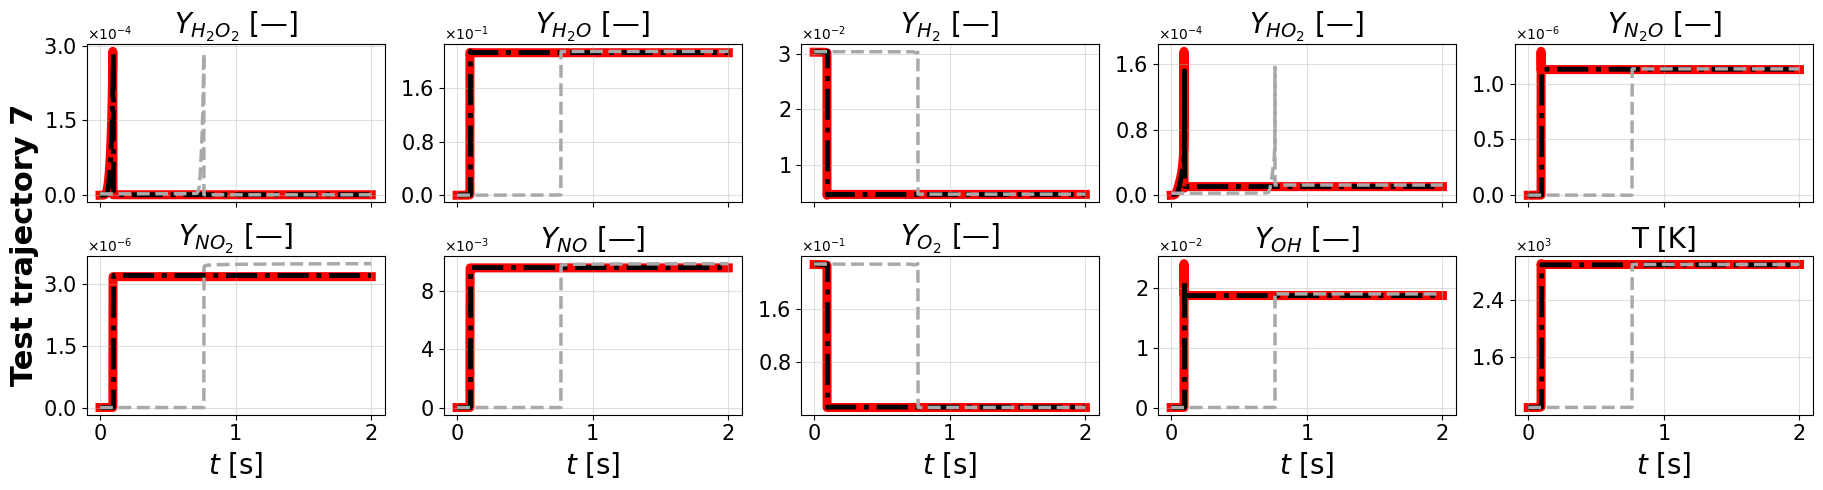

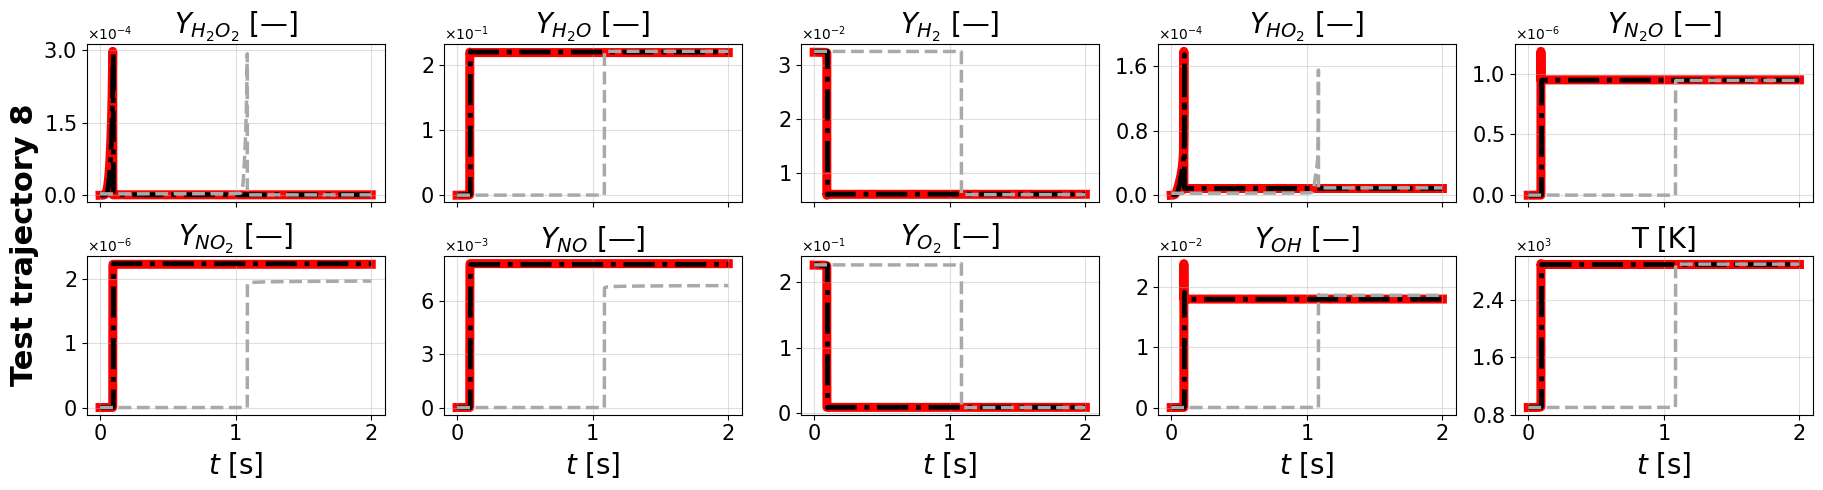

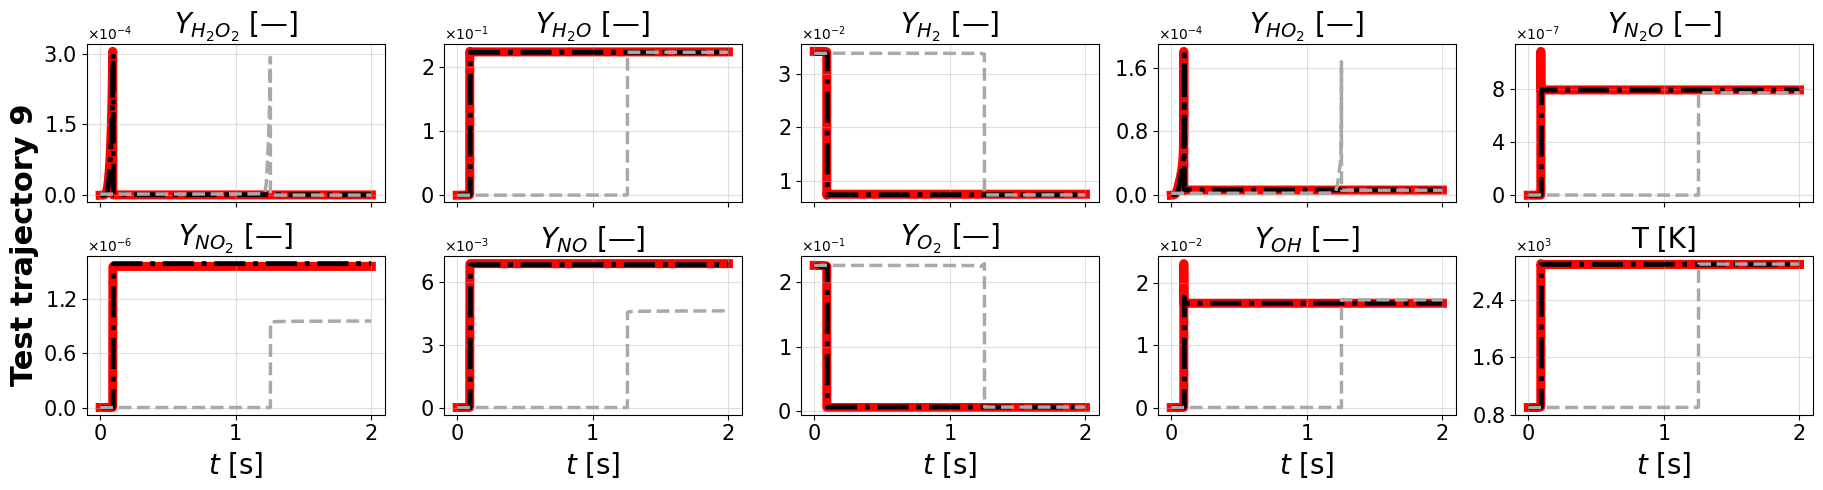

In [25]:
save = True
pathSave = "C:/Users/admin/Documents/Parente/Figures/2024-PV-optimization/Paper/Results/Autoignition/A posteriori simulations/3.2 - ANN/A posteriori/Simulations extended/"
name = f"Heuristic vs optimized {id_model} - A posteriori - ANN - timeExt"

Output_species_Latex = [species.replace('2', '_2') for species in Output_species]

for idxSimulation in range(num_test_trajectories):

    rows, cols = 2, 5

    fig, axes = plt.subplots(rows, cols, figsize=(18, 5))
    axes = axes.flatten()

    with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
            test_trajectory = pd.DataFrame(hf[f'test_trajectory_{idxSimulation}'][:], columns = state_space_names)
    #test time trajectories
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}time-test-trajectories.h5", 'r') as hf:
        test_trajectory_time = pd.DataFrame(hf[f'test_trajectory_{idxSimulation}'][:])
    

    test_trajectory_time = test_trajectory_time.to_numpy().ravel()
    test_trajectory_time = torch.tensor(test_trajectory_time)
    deltaTime = test_trajectory_time[-1] - test_trajectory_time[-2]

    last_value = test_trajectory_time[-1]
    new_times = []

    next_time = last_value + deltaTime
    while next_time <= 2:
        new_times.append(next_time.item())
        next_time += deltaTime

    
    for idxQoI in range(len(Output_species)): 
      ax = axes[idxQoI]

      #Add extension to the current tensor
      if new_times:
          extension = torch.tensor(new_times, dtype=torch.float32)
          test_trajectory_time_ext = torch.cat((test_trajectory_time, extension))

          last_value = test_trajectory[Output_species[idxQoI]].to_numpy()[-1]
          extension = np.tile(last_value, (len(new_times),))  #extension with last value of PV_optimized_test
          test_trajectory_QoI_ext = np.hstack((test_trajectory[Output_species[idxQoI]].to_numpy(), extension)) #concatenate the extension with the original value

      prediction_Xu = (model_regression_full_Xu((list_simulations_Xu_ext[idxSimulation][:]-mins_input_full_Xu)/(maxs_input_full_Xu-mins_input_full_Xu) - 0.5) + 1) /2 * (maxs_output_full_Xu - mins_output_full_Xu) + mins_output_full_Xu
      prediction_Xu = prediction_Xu.detach().numpy()

      prediction_optimized = (model_regression_full_optimized((list_simulations_optimized_ext[idxSimulation][:]-mins_input_full_optimized)/(maxs_input_full_optimized-mins_input_full_optimized) - 0.5) + 1) /2 * (maxs_output_full_optimized - mins_output_full_optimized) + mins_output_full_optimized
      prediction_optimized = prediction_optimized.detach().numpy()
      
      ax.plot(test_trajectory_time_ext, test_trajectory_QoI_ext, label = "FOM", c="red", linestyle="-", linewidth=6.5, zorder = 1)  # True trajectory
      ax.plot(test_trajectory_time_ext, prediction_Xu[:, idxQoI], label = "ROM with the heuristic PV", c="darkgrey", linestyle="--", linewidth=2.5, zorder = 3)
      ax.plot(test_trajectory_time_ext, prediction_optimized[:, idxQoI], label = "ROM with the optimized PV", c="k", linestyle="dashdot", linewidth=3.5, zorder = 2)
      
      if(Output_species[idxQoI] == "T"):
        ax.set_title(f"T [K]", fontsize = 20)
      else:
         ax.set_title(f"$Y_{{{Output_species_Latex[idxQoI]}}}$ [\u2014]", fontsize = 20)


      ax.tick_params(axis='x', labelsize=15) 
      ax.tick_params(axis='y', labelsize=15)

      #ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=3))
      ax.set_xticks([0, 1, 2])
      ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=3))
      if(idxQoI>= num_test_trajectories-cols):
        ax.set_xlabel(f"$t$ [s]", fontsize = 20)
        
      else:
        ax.set_xticklabels([])
      
      formatter = ScalarFormatter(useMathText=True)
      formatter.set_powerlimits((0, 0))
      ax.yaxis.set_major_formatter(formatter)
      ax.grid(True, linestyle='-', alpha=0.4)
          
    for j in range(len(Output_species), len(axes)): #disables axes of plots not used
      axes[j].axis("off")
    
    handles, labels = axes[0].get_legend_handles_labels()
    legend_handles = [
        Line2D([0], [0], color='red', linestyle='-', linewidth=10, label='FOM'),
        Line2D([0], [0], color='darkgrey', linestyle='--', linewidth=5, label='ROM with the heuristic PV'),
        Line2D([0], [0], color='k', linestyle='dashdot', linewidth=5, label='ROM with the optimized PV'),
    ]
    if(idxSimulation == 0):
       
      fig.legend(legend_handles, labels,
                  loc='upper center', 
                  bbox_to_anchor=(0.5, 1.14), 
                  ncol=3, 
                  fontsize=23,
                  frameon=True
              )
    
    fig.text(-0.01, 0.5, f"Test trajectory {idxSimulation}", va='center', rotation='vertical', fontsize=22, fontweight='bold')

    plt.tight_layout() #h_pad = 0

    if(save):
        plt.savefig(f"{pathSave}{name}_testTraj{idxSimulation}.png", dpi=300, bbox_inches="tight")
        plt.savefig(f"{pathSave}{name}_testTraj{idxSimulation}.pdf", bbox_inches="tight")

    if(i==0):
        plt.show()

### Figure for paper: Visualize only results for the fifth trajectory

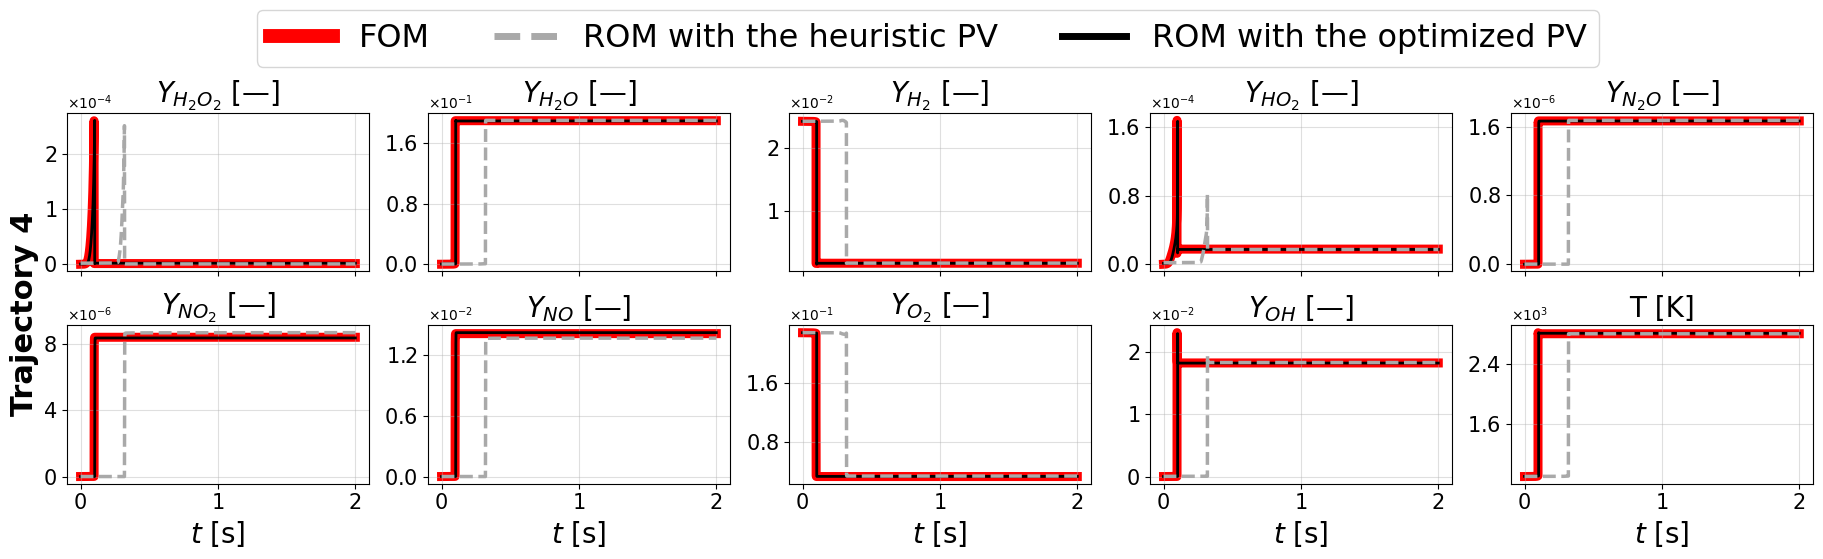

In [96]:
save = True
pathSave = "C:/Users/admin/Documents/Parente/Figures/2024-PV-optimization/Paper/Results/Autoignition/A posteriori simulations/3.2 - ANN/A posteriori/"
name = f"Heuristic vs optimized {id_model} - traj 4 - A posteriori - ANN - timeExt - PAPER.png"

Output_species_Latex = [species.replace('2', '_2') for species in Output_species]

idxSimulation = 4

rows, cols = 2, 5

fig, axes = plt.subplots(rows, cols, figsize=(18, 5))
axes = axes.flatten()

with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
        test_trajectory = pd.DataFrame(hf[f'test_trajectory_{idxSimulation}'][:], columns = state_space_names)
#test time trajectories
with h5py.File(f"{path_data_autoignition}{filename_autoignition}time-test-trajectories.h5", 'r') as hf:
    test_trajectory_time = pd.DataFrame(hf[f'test_trajectory_{idxSimulation}'][:])


test_trajectory_time = test_trajectory_time.to_numpy().ravel()
test_trajectory_time = torch.tensor(test_trajectory_time)
deltaTime = test_trajectory_time[-1] - test_trajectory_time[-2]

last_value = test_trajectory_time[-1]
new_times = []

next_time = last_value + deltaTime
while next_time <= 2:
    new_times.append(next_time.item())
    next_time += deltaTime


for idxQoI in range(len(Output_species)): 
    ax = axes[idxQoI]

    #Add extension to the current tensor
    if new_times:
        extension = torch.tensor(new_times, dtype=torch.float32)
        test_trajectory_time_ext = torch.cat((test_trajectory_time, extension))

        last_value = test_trajectory[Output_species[idxQoI]].to_numpy()[-1]
        extension = np.tile(last_value, (len(new_times),))  #extension with last value of PV_optimized_test
        test_trajectory_QoI_ext = np.hstack((test_trajectory[Output_species[idxQoI]].to_numpy(), extension)) #concatenate the extension with the original value

    prediction_Xu = (model_regression_full_Xu((list_simulations_Xu_ext[idxSimulation][:]-mins_input_full_Xu)/(maxs_input_full_Xu-mins_input_full_Xu) - 0.5) + 1) /2 * (maxs_output_full_Xu - mins_output_full_Xu) + mins_output_full_Xu
    prediction_Xu = prediction_Xu.detach().numpy()

    prediction_optimized = (model_regression_full_optimized((list_simulations_optimized_ext[idxSimulation][:]-mins_input_full_optimized)/(maxs_input_full_optimized-mins_input_full_optimized) - 0.5) + 1) /2 * (maxs_output_full_optimized - mins_output_full_optimized) + mins_output_full_optimized
    prediction_optimized = prediction_optimized.detach().numpy()
    
    ax.plot(test_trajectory_time_ext, test_trajectory_QoI_ext, label = "FOM", c="red", linestyle="-", linewidth=6.5, zorder = 1)  # True trajectory
    ax.plot(test_trajectory_time_ext, prediction_Xu[:, idxQoI], label = "ROM with the heuristic PV", c="darkgrey", linestyle="--", linewidth=2.5, zorder = 3)
    ax.plot(test_trajectory_time_ext, prediction_optimized[:, idxQoI], label = "ROM with the optimized PV", c="k", linestyle="-", linewidth=2, zorder = 2)
    
    if(Output_species[idxQoI] == "T"):
        ax.set_title(f"T [K]", fontsize = 20)
    else:
        ax.set_title(f"$Y_{{{Output_species_Latex[idxQoI]}}}$ [\u2014]", fontsize = 20)


    ax.tick_params(axis='x', labelsize=15) 
    ax.tick_params(axis='y', labelsize=15)

    #ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=3))
    ax.set_xticks([0, 1, 2])
    ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=3))
    if(idxQoI>= num_test_trajectories-cols):
        ax.set_xlabel(f"$t$ [s]", fontsize = 20)
    
    else:
        ax.set_xticklabels([])
    
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((0, 0))
    ax.yaxis.set_major_formatter(formatter)
    ax.grid(True, linestyle='-', alpha=0.4)
        

handles, labels = axes[0].get_legend_handles_labels()
legend_handles = [
    Line2D([0], [0], color='red', linestyle='-', linewidth=10, label='FOM'),
    Line2D([0], [0], color='darkgrey', linestyle='--', linewidth=5, label='ROM with the heuristic PV'),
    Line2D([0], [0], color='k', linestyle='-', linewidth=5, label='ROM with the optimized PV'),
]
    
fig.legend(legend_handles, labels,
            loc='upper center', 
            bbox_to_anchor=(0.5, 1.14), 
            ncol=3, 
            fontsize=23,
            frameon=True
        )

fig.text(-0.01, 0.5, f"Trajectory {idxSimulation}", va='center', rotation='vertical', fontsize=22, fontweight='bold')

plt.tight_layout() #h_pad = 0

if(save):
    plt.savefig(f"{pathSave}{name}_testTraj{idxSimulation}.png", dpi=1000, bbox_inches="tight")
    plt.savefig(f"{pathSave}{name}_testTraj{idxSimulation}.pdf", bbox_inches="tight")
if(i==0):
    plt.show()

### Figure for graphical abstract

C:\Windows\Temp\ipykernel_23604\2504123971.py:55: RuntimeWarning: divide by zero encountered in divide
  true_curve = (PV_Xu_test_ext-min_PV)/(max_PV-max_PV)
C:\Windows\Temp\ipykernel_23604\2504123971.py:55: RuntimeWarning: invalid value encountered in divide
  true_curve = (PV_Xu_test_ext-min_PV)/(max_PV-max_PV)


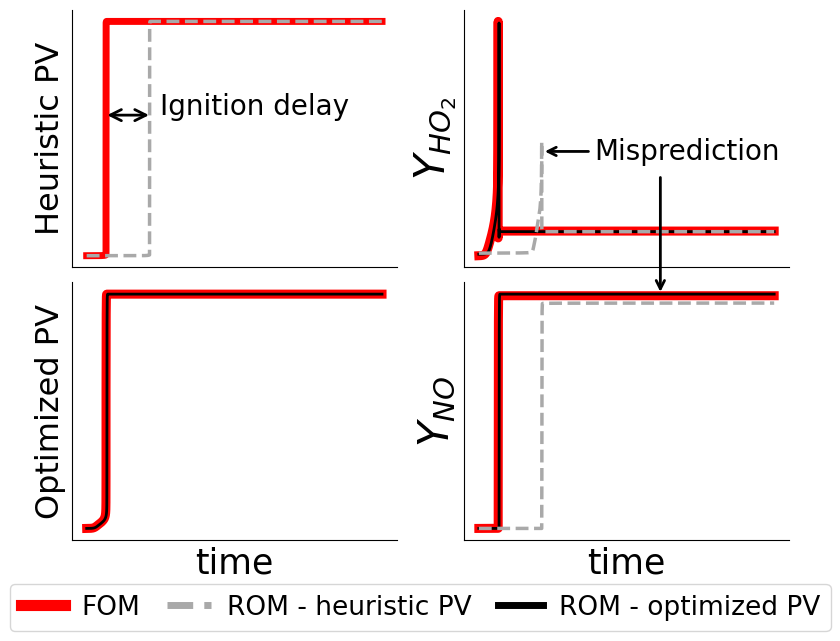

In [95]:
# --- Set parameters ---
save = True
pathSave = "C:/Users/admin/Documents/Parente/Figures/2024-PV-optimization/Paper/Results/Autoignition/A posteriori simulations/3.2 - ANN/A posteriori/"
name = f"Heuristic vs optimized {id_model} - traj 4 - A posteriori - ANN - combined - graphical abstract with time"

i = 4
idxSimulation = 4
arrayHO2andNO = np.array([3, 6])  # Example indices
Output_species_Latex = [species.replace('2', '_2') for species in Output_species]

# --- Create 2x2 figure ---
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
(ax1, ax2), (ax3, ax4) = axes

# ================================================================
# TOP LEFT: Heuristic PV
# ================================================================
with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
    test_trajectory = pd.DataFrame(hf[f'test_trajectory_{i}'][:], columns=state_space_names)
    PV_Xu_test = (test_trajectory["H2O"] if Xu_H2O == "H2O" 
                  else test_trajectory["H2O"] - test_trajectory["H2"] - test_trajectory["O2"])
    PV_Xu_test = PV_Xu_test.to_numpy().reshape(-1, 1)
    f_PV_Xu_test = np.hstack((np.full(PV_Xu_test.shape[0], mixture_fractions_test[i]).reshape(-1, 1), PV_Xu_test))

with h5py.File(f"{path_data_autoignition}{filename_autoignition}time-test-trajectories.h5", 'r') as hf:
    test_trajectory_time = pd.DataFrame(hf[f'test_trajectory_{i}'][:]).to_numpy().ravel()

test_trajectory_time = torch.tensor(test_trajectory_time)
deltaTime = test_trajectory_time[-1] - test_trajectory_time[-2]

# Extend time and PV
last_value = test_trajectory_time[-1]
new_times, next_time = [], last_value + deltaTime
while next_time <= 1.5:
    new_times.append(next_time.item())
    next_time += deltaTime



test_trajectory_time_ext = torch.cat((test_trajectory_time, torch.tensor(new_times, dtype=torch.float32)))
PV_Xu_test_ext = np.vstack((PV_Xu_test, np.tile(PV_Xu_test[-1], (len(new_times), 1))))

min_PV, max_PV = PV_Xu_test_ext.min(), PV_Xu_test_ext.max()

ax1.plot(test_trajectory_time_ext, (PV_Xu_test_ext-min_PV)/(max_PV-min_PV), 
         label="FOM", color="red", linestyle="-", linewidth=5)
ax1.plot(test_trajectory_time_ext, 
         (list_simulations_Xu_ext[i][:len(test_trajectory_time_ext),1].detach().numpy()-min_PV)/(max_PV-min_PV),
         label="ROM with a PV", color="darkgrey", linewidth=2.5, linestyle = "--")
ax1.set_ylabel('Heuristic PV', fontsize=23)
ax1.set_xticks([]); ax1.set_yticks([])
ax1.spines['top'].set_visible(False); ax1.spines['right'].set_visible(False)

# Add ignition delay arrow
true_curve = (PV_Xu_test_ext-min_PV)/(max_PV-max_PV)
true_times = test_trajectory_time_ext.numpy()
pred_curve = (list_simulations_Xu_ext[i][:,1].detach().numpy()-min_PV)/(max_PV-min_PV)
t_true = true_times[np.argmax(true_curve >= 0.99)]
t_pred = true_times[np.argmax(pred_curve >= 0.99)]
arrow = FancyArrowPatch((t_true+0.09, 0.6), (t_pred+0.01, 0.6),
                        arrowstyle="<->", color="black", linewidth=2,
                        mutation_scale=20, zorder = 5)
ax1.add_patch(arrow)
ax1.text(t_pred + 0.05, 0.6, "Ignition delay", fontsize=20)

# ================================================================
# BOTTOM LEFT: Optimized PV
# ================================================================
with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
    test_trajectory = pd.DataFrame(hf[f'test_trajectory_{i}'][:], columns=state_space_names)
    state_space_test_DNS = test_trajectory[state_space_names_DNS].to_numpy()
    PV_optimized_test = PV_model.get_PV(torch.from_numpy(np.delete(state_space_test_DNS, idx_species_removed, axis=1))).detach().numpy()

test_trajectory_time_ext = torch.cat((test_trajectory_time, torch.tensor(new_times, dtype=torch.float32)))
PV_optimized_test_ext = np.vstack((PV_optimized_test, np.tile(PV_optimized_test[-1], (len(new_times), 1))))
min_PV, max_PV = PV_optimized_test.min(), PV_optimized_test.max()

ax3.plot(test_trajectory_time_ext, (PV_optimized_test_ext-min_PV)/(max_PV-min_PV),
         label="FOM", color="red", linewidth=6.5)
ax3.plot(test_trajectory_time_ext,
         (list_simulations_optimized_ext[i].squeeze()[:len(test_trajectory_time_ext),1].detach().numpy()-min_PV)/(max_PV-min_PV),
         label="ROM with a PV", color="k", linewidth=2)
ax3.set_ylabel('Optimized PV', fontsize=23)
ax3.set_xticks([]); ax3.set_yticks([])
ax3.spines['top'].set_visible(False); ax3.spines['right'].set_visible(False)
ax3.set_xlabel("time", fontsize = 25)
ax4.set_xlabel("time", fontsize = 25)

# ================================================================
# RIGHT PLOTS: HO2 and NO
# ================================================================
with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
    test_trajectory = pd.DataFrame(hf[f'test_trajectory_{idxSimulation}'][:], columns=state_space_names)
with h5py.File(f"{path_data_autoignition}{filename_autoignition}time-test-trajectories.h5", 'r') as hf:
    test_trajectory_time = pd.DataFrame(hf[f'test_trajectory_{idxSimulation}'][:]).to_numpy().ravel()
test_trajectory_time_ext = torch.cat((torch.tensor(test_trajectory_time),
                                      torch.tensor(new_times, dtype=torch.float32)))

for idxAx, idxQoI, ax in zip(range(2), arrayHO2andNO, [ax2, ax4]):
    test_trajectory_QoI_ext = np.hstack((
        test_trajectory[Output_species[idxQoI]].to_numpy(),
        np.tile(test_trajectory[Output_species[idxQoI]].to_numpy()[-1], len(new_times))
    ))

    pred_Xu = (model_regression_full_Xu((list_simulations_Xu_ext[idxSimulation][:]-mins_input_full_Xu)/
                                        (maxs_input_full_Xu-mins_input_full_Xu)-0.5)+1)/2*(
              maxs_output_full_Xu - mins_output_full_Xu) + mins_output_full_Xu
    pred_optimized = (model_regression_full_optimized((list_simulations_optimized_ext[idxSimulation][:]-mins_input_full_optimized)/
                                                      (maxs_input_full_optimized-mins_input_full_optimized)-0.5)+1)/2*(
              maxs_output_full_optimized - mins_output_full_optimized) + mins_output_full_optimized
    pred_Xu = pred_Xu.detach().numpy()
    pred_optimized = pred_optimized.detach().numpy()

    ax.plot(test_trajectory_time_ext, test_trajectory_QoI_ext, label="FOM", c="red", linewidth=6.5)
    ax.plot(test_trajectory_time_ext, pred_Xu[:len(test_trajectory_time_ext), idxQoI], label="ROM - heuristic PV", c="darkgrey", linestyle="--", linewidth = 2.5, zorder = 3)
    ax.plot(test_trajectory_time_ext, pred_optimized[:len(test_trajectory_time_ext), idxQoI], label="ROM - optimized PV", c="k", linewidth = 2)
    ax.set_ylabel(f"$Y_{{{Output_species_Latex[idxQoI]}}}$", fontsize=30)
    ax.set_xticks([]); ax.set_yticks([])
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)


ax2.annotate(
    "Misprediction",
    xy=(0.24, 0.45), xycoords='axes fraction',  # arrow tip
    xytext=(0.4, 0.45), textcoords='axes fraction',  # text position
    arrowprops=dict(
        arrowstyle="->",
        color="black",
        linewidth=2,
        mutation_scale=15
    ),
    fontsize=20,
    ha="left",
    va="center"
)

fig = plt.gcf()

# Coordinates in figure fraction: (0,0) bottom-left of the whole figure, (1,1) top-right
# You'll need to tune these numbers by trial to align with the subplot positions
arrow = FancyArrowPatch(
    (0.8, 0.7),   # start point (e.g., misprediction on ax3)
    (0.8, 0.5),   # end point (e.g., target inside ax4)
    transform=fig.transFigure,
    arrowstyle="->",
    color="black",
    linewidth=2,
    mutation_scale=15,
    connectionstyle="arc3,rad=0.0"  # straight line, adjust rad for curved
)

fig.patches.append(arrow)

# Legend
legend_handles = [
    Line2D([0], [0], color='red', linewidth=8, label='FOM'),
    Line2D([0], [0], color='darkgrey', linestyle='--', linewidth=5, label='ROM - heuristic PV'),
    Line2D([0], [0], color='k', linewidth=5, label='ROM - optimized PV'),
]
fig.legend(legend_handles, [h.get_label() for h in legend_handles],
           loc='upper center', bbox_to_anchor=(0.5, 0.04), ncol=3, fontsize=19,
            handlelength=1.7, handletextpad=0.6, columnspacing=1)

plt.tight_layout()

if save:
    plt.savefig(f"{pathSave}{name}.png", dpi=1000, bbox_inches="tight")
    plt.savefig(f"{pathSave}{name}.pdf", bbox_inches="tight")
plt.show()


### Metrics for a posteriori simulations: Min, median and max error of relative error of max and SS

In [19]:
from collections import defaultdict
import numpy as np

# Store errors per species
errors_max_heuristic = defaultdict(list)
errors_last_heuristic = defaultdict(list)
errors_max_optimized = defaultdict(list)
errors_last_optimized = defaultdict(list)

for i in range(10):
    # --- Predictions ---
    prediction_Xu = (model_regression_full_Xu(
        (list_simulations_Xu_ext[i][:]-mins_input_full_Xu)/(maxs_input_full_Xu-mins_input_full_Xu) - 0.5
    ) + 1) / 2 * (maxs_output_full_Xu - mins_output_full_Xu) + mins_output_full_Xu
    prediction_Xu = prediction_Xu.detach().numpy()

    prediction_optimized = (model_regression_full_optimized(
        (list_simulations_optimized_ext[i][:]-mins_input_full_optimized)/(maxs_input_full_optimized-mins_input_full_optimized) - 0.5
    ) + 1) / 2 * (maxs_output_full_optimized - mins_output_full_optimized) + mins_output_full_optimized
    prediction_optimized = prediction_optimized.detach().numpy()

    # --- Ground truth trajectory ---
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
        test_trajectory = pd.DataFrame(hf[f'test_trajectory_{i}'][:], columns=state_space_names)

    for j, species in enumerate(Output_species):
        trueValues = test_trajectory[species].to_numpy()

        max_true = np.max(trueValues)
        last_true = trueValues[-1]

        max_pred_heuristic = np.max(prediction_Xu[:, j])
        last_pred_heuristic = prediction_Xu[-1, j]

        max_pred_optimized = np.max(prediction_optimized[:, j])
        last_pred_optimized = prediction_optimized[-1, j]

        # --- Relative errors (normalize by |max_true|) ---
        if max_true != 0:
            err_max_h = abs(max_true - max_pred_heuristic) / abs(max_true)
            err_last_h = abs(last_true - last_pred_heuristic) / abs(max_true)

            err_max_o = abs(max_true - max_pred_optimized) / abs(max_true)
            err_last_o = abs(last_true - last_pred_optimized) / abs(max_true)

            errors_max_heuristic[species].append(err_max_h)
            errors_last_heuristic[species].append(err_last_h)
            errors_max_optimized[species].append(err_max_o)
            errors_last_optimized[species].append(err_last_o)

# --- Aggregate results ---
results = {}
for species in Output_species:
    results[species] = {
        "heuristic": {
            "max_error": {
                "min": float(np.min(errors_max_heuristic[species])),
                "median": float(np.median(errors_max_heuristic[species])),
                "max": float(np.max(errors_max_heuristic[species]))
            },
            "last_error": {
                "min": float(np.min(errors_last_heuristic[species])),
                "median": float(np.median(errors_last_heuristic[species])),
                "max": float(np.max(errors_last_heuristic[species]))
            },
        },
        "optimized": {
            "max_error": {
                "min": float(np.min(errors_max_optimized[species])),
                "median": float(np.median(errors_max_optimized[species])),
                "max": float(np.max(errors_max_optimized[species]))
            },
            "last_error": {
                "min": float(np.min(errors_last_optimized[species])),
                "median": float(np.median(errors_last_optimized[species])),
                "max": float(np.max(errors_last_optimized[species]))
            },
        }
    }

# Print nicely
import pprint
pprint.pprint(results, width=120)

{'H2': {'heuristic': {'last_error': {'max': 0.004009769938928244,
                                     'median': 0.0020182098161894793,
                                     'min': 0.0004963949102193765},
                      'max_error': {'max': 0.025078197031694387,
                                    'median': 0.008410968628485904,
                                    'min': 0.000696185101922814}},
        'optimized': {'last_error': {'max': 0.003023622918363102,
                                     'median': 0.001117195764493774,
                                     'min': 3.3275316073204775e-05},
                      'max_error': {'max': 0.00820104701071947,
                                    'median': 0.00395775097342361,
                                    'min': 0.000421479554245687}}},
 'H2O': {'heuristic': {'last_error': {'max': 0.009046358859373535,
                                      'median': 0.00472088321340107,
                                      'min': 0.0016464726

#### Table for supplementary material

In [25]:
def results_to_latex(results, output_species):
    header = (
        "\\begin{table}[h]\n"
        "\\centering\n"
        "\\renewcommand{\\arraystretch}{1.2}\n"
        "\\begin{tabular}{l|" + "c" * 12 + "}\n"
        "\\hline\n"
        " & \\multicolumn{6}{c|}{Max} & \\multicolumn{6}{c}{Last} \\\\\n"
        "Species & \\multicolumn{3}{c|}{Heuristic} & \\multicolumn{3}{c|}{Optimized} & "
        "\\multicolumn{3}{c|}{Heuristic} & \\multicolumn{3}{c}{Optimized} \\\\\n"
        " & Min & Median & Max & Min & Median & Max & Min & Median & Max & Min & Median & Max \\\\\n"
        "\\hline\n"
    )

    rows = ""
    for species in output_species:
        r = results[species]
        row = (
            f"{species} & "
            f"{r['heuristic']['max_error']['min']:.1e} & {r['heuristic']['max_error']['median']:.1e} & {r['heuristic']['max_error']['max']:.1e} & "
            f"{r['optimized']['max_error']['min']:.1e} & {r['optimized']['max_error']['median']:.1e} & {r['optimized']['max_error']['max']:.1e} & "
            f"{r['heuristic']['last_error']['min']:.1e} & {r['heuristic']['last_error']['median']:.1e} & {r['heuristic']['last_error']['max']:.1e} & "
            f"{r['optimized']['last_error']['min']:.1e} & {r['optimized']['last_error']['median']:.1e} & {r['optimized']['last_error']['max']:.1e} \\\\\n"
        )
        rows += row

    footer = (
        "\\hline\n"
        "\\end{tabular}\n"
        "\\caption{Relative error statistics (min, median, max) for the maximum value and the last value of each QoI "
        "(heuristic vs optimized). Values are reported in \\%.}\n"
        "\\label{tab:rel_errors}\n"
        "\\end{table}"
    )

    return header + rows + footer

# Example usage:
latex_table = results_to_latex(results, Output_species)
print(latex_table)


\begin{table}[h]
\centering
\renewcommand{\arraystretch}{1.2}
\begin{tabular}{l|cccccccccccc}
\hline
 & \multicolumn{6}{c|}{Max} & \multicolumn{6}{c}{Last} \\
Species & \multicolumn{3}{c|}{Heuristic} & \multicolumn{3}{c|}{Optimized} & \multicolumn{3}{c|}{Heuristic} & \multicolumn{3}{c}{Optimized} \\
 & Min & Median & Max & Min & Median & Max & Min & Median & Max & Min & Median & Max \\
\hline
H2O2 & 8.8e-04 & 2.8e-02 & 2.2e-01 & 7.4e-04 & 5.5e-03 & 1.5e-02 & 1.9e-04 & 1.7e-03 & 1.1e-02 & 3.8e-04 & 1.7e-03 & 4.4e-03 \\
H2O & 2.3e-03 & 4.9e-03 & 1.1e-02 & 4.2e-04 & 3.2e-03 & 7.5e-03 & 1.6e-03 & 4.7e-03 & 9.0e-03 & 9.6e-05 & 2.4e-03 & 4.8e-03 \\
H2 & 7.0e-04 & 8.4e-03 & 2.5e-02 & 4.2e-04 & 4.0e-03 & 8.2e-03 & 5.0e-04 & 2.0e-03 & 4.0e-03 & 3.3e-05 & 1.1e-03 & 3.0e-03 \\
HO2 & 7.2e-02 & 4.6e-01 & 7.0e-01 & 2.0e-03 & 1.9e-02 & 1.4e-01 & 8.8e-04 & 5.7e-03 & 1.1e-02 & 2.0e-04 & 1.8e-03 & 2.8e-03 \\
N2O & 3.2e-03 & 7.2e-02 & 2.9e-01 & 2.6e-04 & 6.2e-02 & 2.7e-01 & 8.6e-04 & 4.6e-03 & 2.0e-02 & 

#### Figure for paper: Summary of the metrics for a posteriori simulations

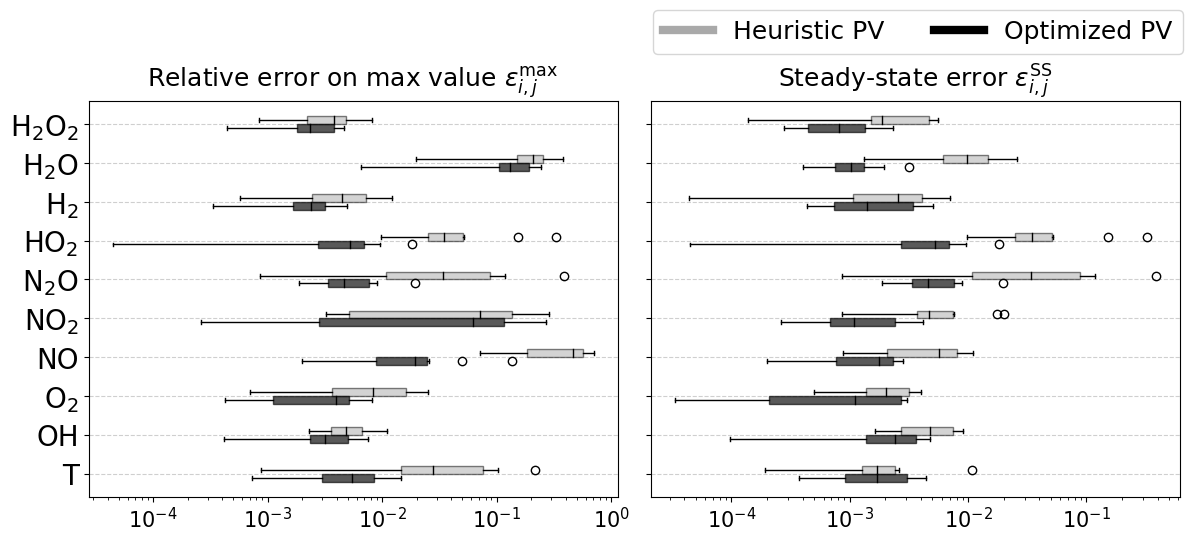

In [23]:
save = True
name = "Boxplots max and SS error - ANN a posteriori 0D.pdf"
pathSave = "C:/Users/Admin/Documents/Parente/Figures/2024-PV-optimization/Paper/Results/Autoignition/A posteriori simulations/3.2 - ANN\A posteriori/"

# --- Prepare data ---
qois = list(results.keys())
n_qoi = len(qois)

# Collect errors in the order of QoIs
SS_heu = [errors_last_heuristic[qoi] for qoi in qois]
SS_opt = [errors_last_optimized[qoi] for qoi in qois]
max_heu   = [errors_max_heuristic[qoi] for qoi in qois]
max_opt   = [errors_max_optimized[qoi] for qoi in qois]

# Positions for horizontal boxplots
y_pos = np.arange(n_qoi)
width = 0.2  # distance between boxes

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# --- Left subplot: Last error ---
for i in range(n_qoi):
    axes[0].boxplot(max_heu[i], positions=[y_pos[i] + width/2], vert=False, widths=width, patch_artist=True,
                    boxprops=dict(facecolor='darkgrey', alpha=0.5),
                    medianprops=dict(color='black'))
    axes[0].boxplot(max_opt[i], positions=[y_pos[i] - width/2], vert=False, widths=width, patch_artist=True,
                    boxprops=dict(facecolor='black', alpha=0.65),
                    medianprops=dict(color='black'))

axes[0].set_yticks(y_pos)
axes[0].set_yticklabels(qois)
axes[0].set_title(r"Relative error on max value $\varepsilon^{\max}_{i,j}$", fontsize = 18)
axes[0].set_xscale("log")
axes[0].grid(axis="y", linestyle="--", alpha=0.6)

# --- Right subplot: Steady-state error ---
for i in range(n_qoi):
    axes[1].boxplot(SS_heu[i], positions=[y_pos[i] + width/2], vert=False, widths=width, patch_artist=True,
                    boxprops=dict(facecolor='darkgrey', alpha=0.5),
                    medianprops=dict(color='black'))
    axes[1].boxplot(SS_opt[i], positions=[y_pos[i] - width/2], vert=False, widths=width, patch_artist=True,
                    boxprops=dict(facecolor='black', alpha=0.65),
                    medianprops=dict(color='black'))

axes[1].set_yticks(y_pos)
axes[1].set_yticklabels([q.replace("2", "$_2$") for q in qois[::-1]])
axes[1].set_title(r"Steady-state error $\varepsilon^{\mathrm{SS}}_{i,j}$", fontsize = 18)
axes[1].set_xscale("log")
axes[0].tick_params(axis='both', labelsize=20)  # y-tick labels
axes[0].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].grid(axis="y", linestyle="--", alpha=0.6)

# --- Legend ---
handles = [
    mlines.Line2D([0], [0], color='darkgrey', lw=6),
    mlines.Line2D([0], [0], color='black', lw=6)
]

labels = ['Heuristic PV', 'Optimized PV']

# Add legend to the figure (not tied to any subplot)
fig.legend(handles, labels, bbox_to_anchor=(1, 1.1), ncol=2, fontsize=18)

plt.tight_layout()
plt.savefig(pathSave + name, bbox_inches = "tight")
plt.show()